Here, I jointly process and analyze the 5' liver from 10x and the XYZeq data. We decided to use the 5' data because Derek showed good projection overlap of that dataset with the 10x using the ingest function.

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns

import json
import requests
from IPython.display import display, HTML
import bbknn
import time

In [170]:
print(sc.__version__)

1.4.4.post1


In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [3]:
prefix = '/data/xyzeq/'

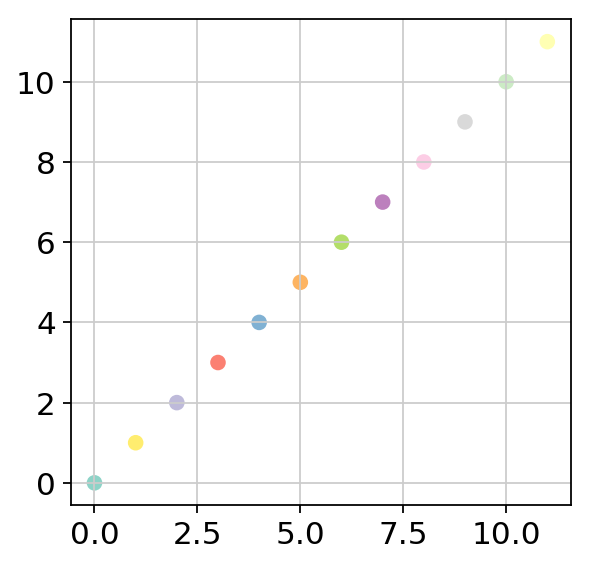

In [4]:
plt.scatter(np.arange(12), np.arange(12), c=['#8DD3C7', '#FFED6F', '#BEBADA', '#FB8072', '#80B1D3', '#FDB462', '#B3DE69', '#BC80BD', '#FCCDE5', '#D9D9D9', '#CCEBC5', '#FFFFB3'])
colors = dict(zip(['turq','dark yel','light purp','coral','blue','orange','light gr','purp','pink','gray','mint','light yel'],
                  ['#8DD3C7', '#FFED6F', '#BEBADA', '#FB8072', '#80B1D3', '#FDB462', '#B3DE69', '#BC80BD', '#FCCDE5', '#D9D9D9', '#CCEBC5', '#FFFFB3']))

# Load in the Datasets

### Load in the XYZeq data

In [5]:
l20c1_prefix = prefix + 'xyzeq/individual.raw.and.proc.h5ads/fig3.L20C1/'
l20c1_raw = sc.read_h5ad(l20c1_prefix + 'adata.1.h5ad')
l20c1 = sc.read_h5ad(l20c1_prefix + 'adata.6.h5ad')

In [6]:
# l20c1_h = l20c1[:,[i for i in l20c1.var_names if i.startswith('hg19_')]].copy()
# l20c1_h = l20c1_h[l20c1_h.obs['celltype'] == 'Hek293t'].copy()

In [7]:
# l20c1_m = l20c1[:,[i for i in l20c1.var_names if i.startswith('mm10_')]].copy()
# l20c1_m = l20c1_m[l20c1_m.obs['celltype'] != 'Hek293t'].copy()

In [8]:
# l20c1_m.var_names = [i[5:] for i in l20c1_m.var_names]

In [9]:
new_names = list()
for i in l20c1.var_names:
    if i.startswith('hg19_'):
        new_names.append('H_' + i[5:])
    else:
        new_names.append('m_' + i[5:])
l20c1.var_names = new_names

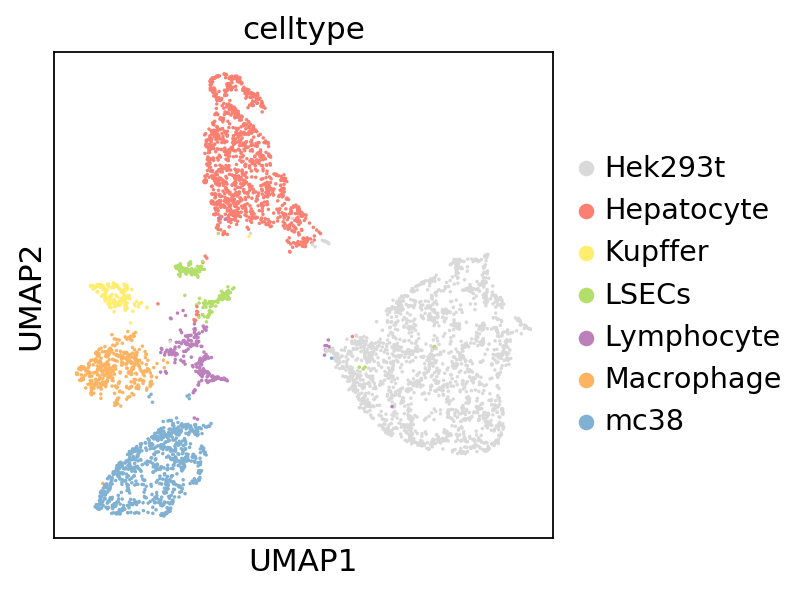

In [10]:
sc.pl.umap(l20c1,color=['celltype'], size=10)

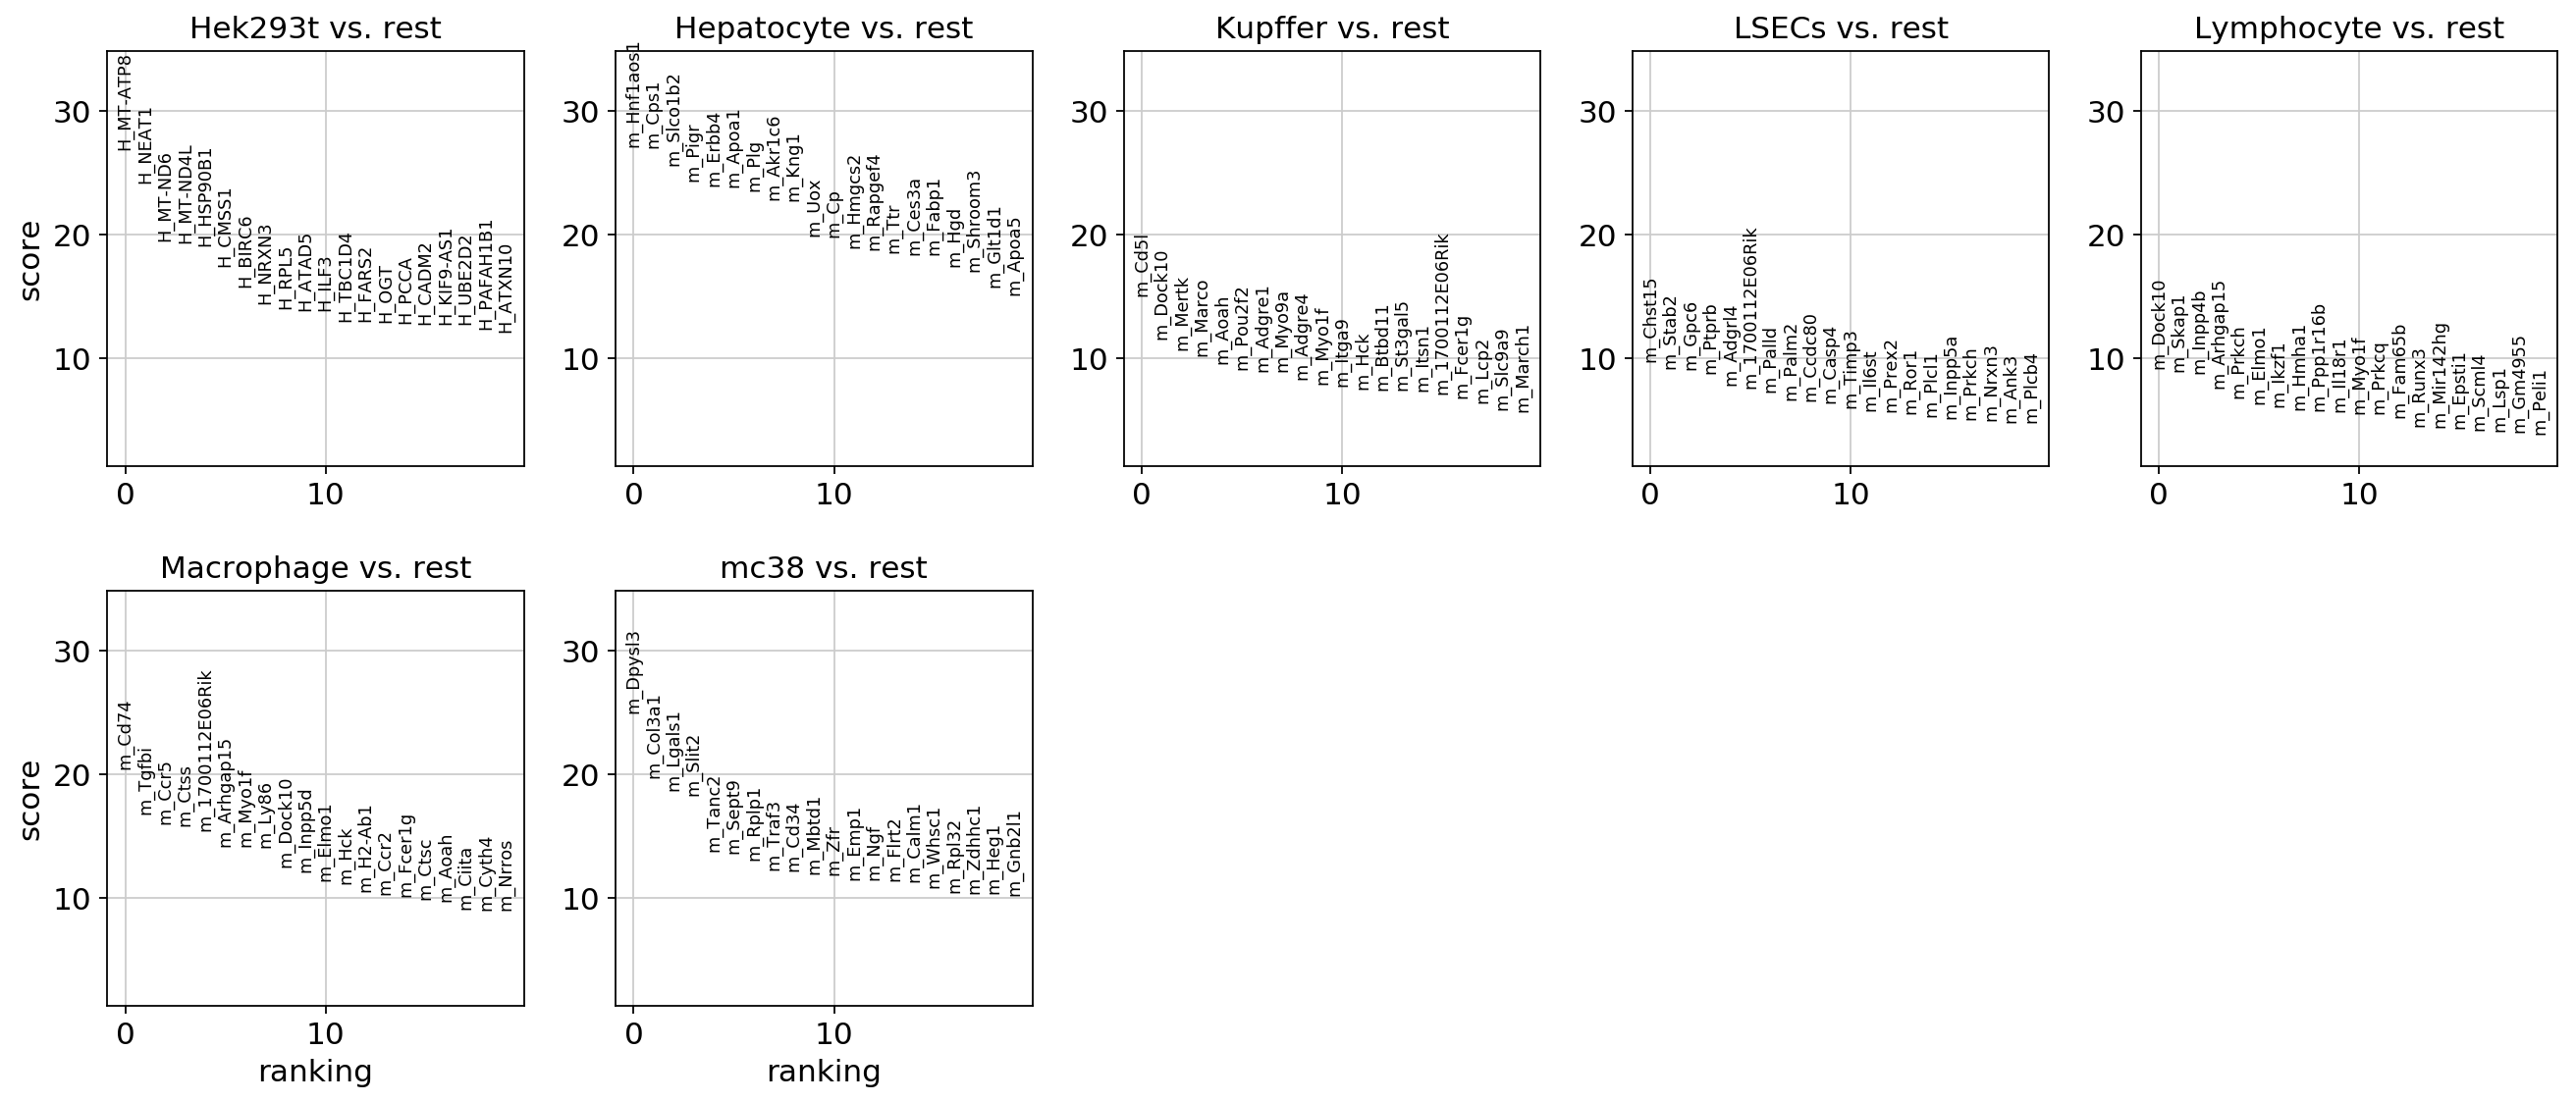

In [11]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(l20c1, groupby='celltype', use_raw=False)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(l20c1, ncols=5)
sc.settings.verbosity = 3

In [12]:
ctdict = dict()
ctdict['XYZ_HEPATOCYTE'] = ['Hepatocyte']
ctdict['XYZ_MPHAGE'] = ['Macrophage']
ctdict['XYZ_KUPFFER'] = ['Kupffer']
ctdict['XYZ_LSEC'] = ['LSECs']
ctdict['XYZ_LYMPH'] = ['Lymphocyte']
ctdict['XYZ_MC38'] = ['mc38']
ctdict['XYZ_HEK293T'] = ['Hek293t']
l20c1.obs['celltype2'] = l20c1.obs['celltype']
for ct in ctdict:
    for clust in ctdict[ct]:
        l20c1.obs['celltype2'].replace(r'^%s$' % str(clust),ct, regex=True, inplace=True)
l20c1.obs['celltype2'] = l20c1.obs['celltype2'].astype('category')

In [13]:
l20c1.uns['celltype2_colors'] = [
    colors['gray'],
    colors['coral'],
    colors['dark yel'],
    colors['light gr'],
    colors['purp'],
    colors['blue'],
    colors['orange']
]

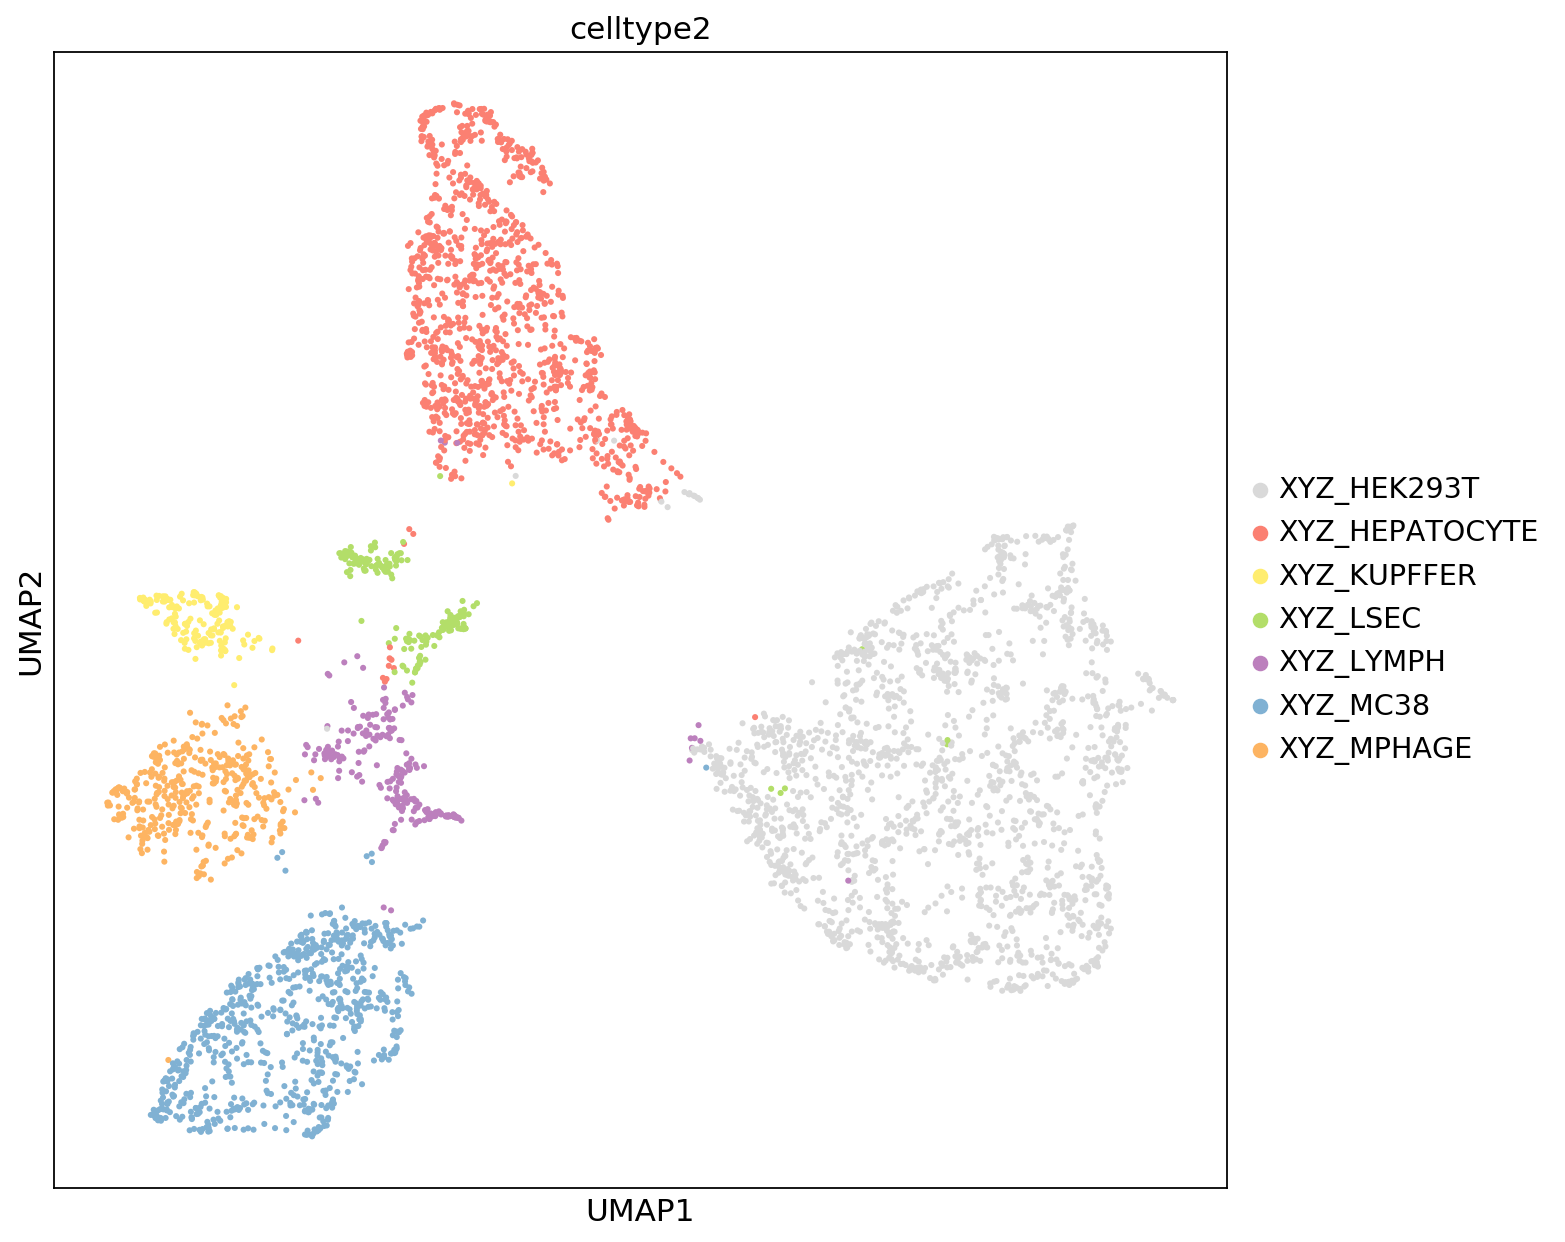

In [14]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
sc.pl.umap(l20c1,color=['celltype2'], size=30, ax=ax, return_fig=False, show=False)
plt.tight_layout()
plt.savefig(prefix + '10x/2020112/figures2/XYZeq.umap.pdf')

### Load in the 10x data

In [201]:
data = dict()
data['adata_original'] = sc.read_10x_h5(prefix + '10x/5prime_liver/outs/raw_feature_bc_matrix.h5').copy()
data['adata_original'].var_names_make_unique()

data['adata'] = sc.read_h5ad(prefix + '/10x/5prime_liver/20200112/20200112_2.h5ad') # use the one Derek created
# data['adata'] = sc.read_h5ad(prefix + '10x/5prime_liver/20200112/20200112_2.recreated.h5ad') # use the one I recreated from Derek's HTML

data['adata_raw'] = data['adata'].raw._adata.copy()

reading /data/xyzeq/10x/5prime_liver/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [202]:
data['adata_original'].shape

(737280, 64591)

In [203]:
new_names = list()
for i in data['adata'].var_names:
    if i.startswith('GRCh38_'):
        new_names.append('H_' + i[7:])
    else:
        new_names.append('m_' + i[7:])
data['adata'].var_names = new_names

In [204]:
new_names = list()
for i in data['adata_original'].var_names:
    if i.startswith('GRCh38_'):
        new_names.append('H_' + i[7:])
    else:
        new_names.append('m_' + i[7:])
data['adata_original'].var_names = new_names

In [205]:
new_names = list()
for i in data['adata'].raw._var.index:
    if i.startswith('GRCh38_'):
        new_names.append('H_' + i[7:])
    else:
        new_names.append('m_' + i[7:])
data['adata'].raw._var.index = new_names

In [206]:
data['adata'].var_names

Index(['H_RHOB', 'H_CCDC58', 'H_GMPS', 'H_NSUN2', 'H_LMNB1', 'H_HIST1H1C',
       'H_HIST1H1E', 'H_NEFM', 'H_NEFL', 'H_SDCBP',
       ...
       'm_Pank1', 'm_Rbp4', 'm_Cyp2c29', 'm_Cyp2c50', 'm_Cyp2c23', 'm_Elovl3',
       'm_As3mt', 'm_Dusp5', 'm_Bbip1', 'm_Zdhhc6'],
      dtype='object', length=679)

In [207]:
common_genes = np.intersect1d(l20c1.var_names.values, data['adata'].var_names.values)

In [208]:
data['adata'] = data['adata'][:,common_genes].copy()

In [209]:
sc.pp.pca(data['adata'],n_comps=50)
sc.pp.neighbors(data['adata'],n_neighbors=15, n_pcs=12)
sc.tl.umap(data['adata'], min_dist=.2, spread=1, alpha=1)
# sc.tl.umap(data['adata'])
sc.tl.leiden(data['adata'], resolution=1)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    using 'X_pca' with n_pcs = 12
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs

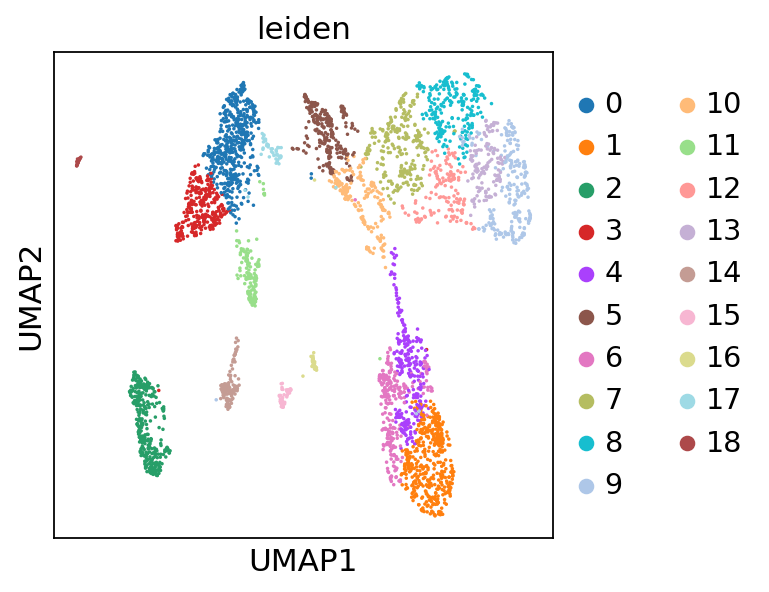

In [210]:
sc.pl.umap(data['adata'],color=['leiden'], size=10, palette=sc.pl.palettes.default_20)

In [211]:
data['adata'].shape

(4027, 68)

In [212]:
groupings = [[5, 7, 8, 9, 10, 12, 13],
             [1, 4, 6],
             [0, 3, 17],
             ]
grouped_clusts = [i for j in groupings for i in j]
numclusts = np.unique(data['adata'].obs['leiden'].values.astype(int))
for i in np.setdiff1d(numclusts, grouped_clusts):
    groupings.append([i])

In [213]:
ctdict = dict()
for i in range(len(groupings)):
    ctdict['ct%s' % str(i)] = groupings[i]

data['adata'].obs['celltype'] = data['adata'].obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        data['adata'].obs['celltype'].replace(r'^%s$' % str(clust), ct, regex=True, inplace=True)
data['adata'].obs['leiden'] = [i.strip('ct') for i in data['adata'].obs['celltype'].astype('category')]

... storing 'leiden' as categorical
... storing 'celltype' as categorical


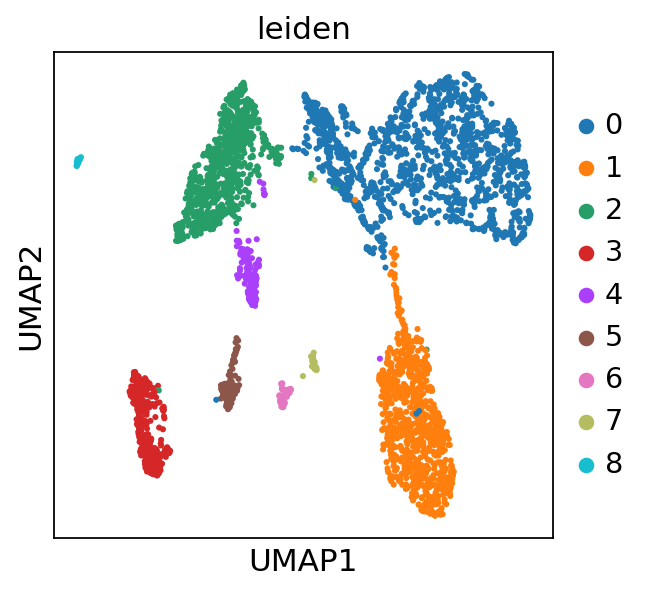

In [214]:
sc.pl.umap(data['adata'],color=['leiden'], size=30,);

### Annotation

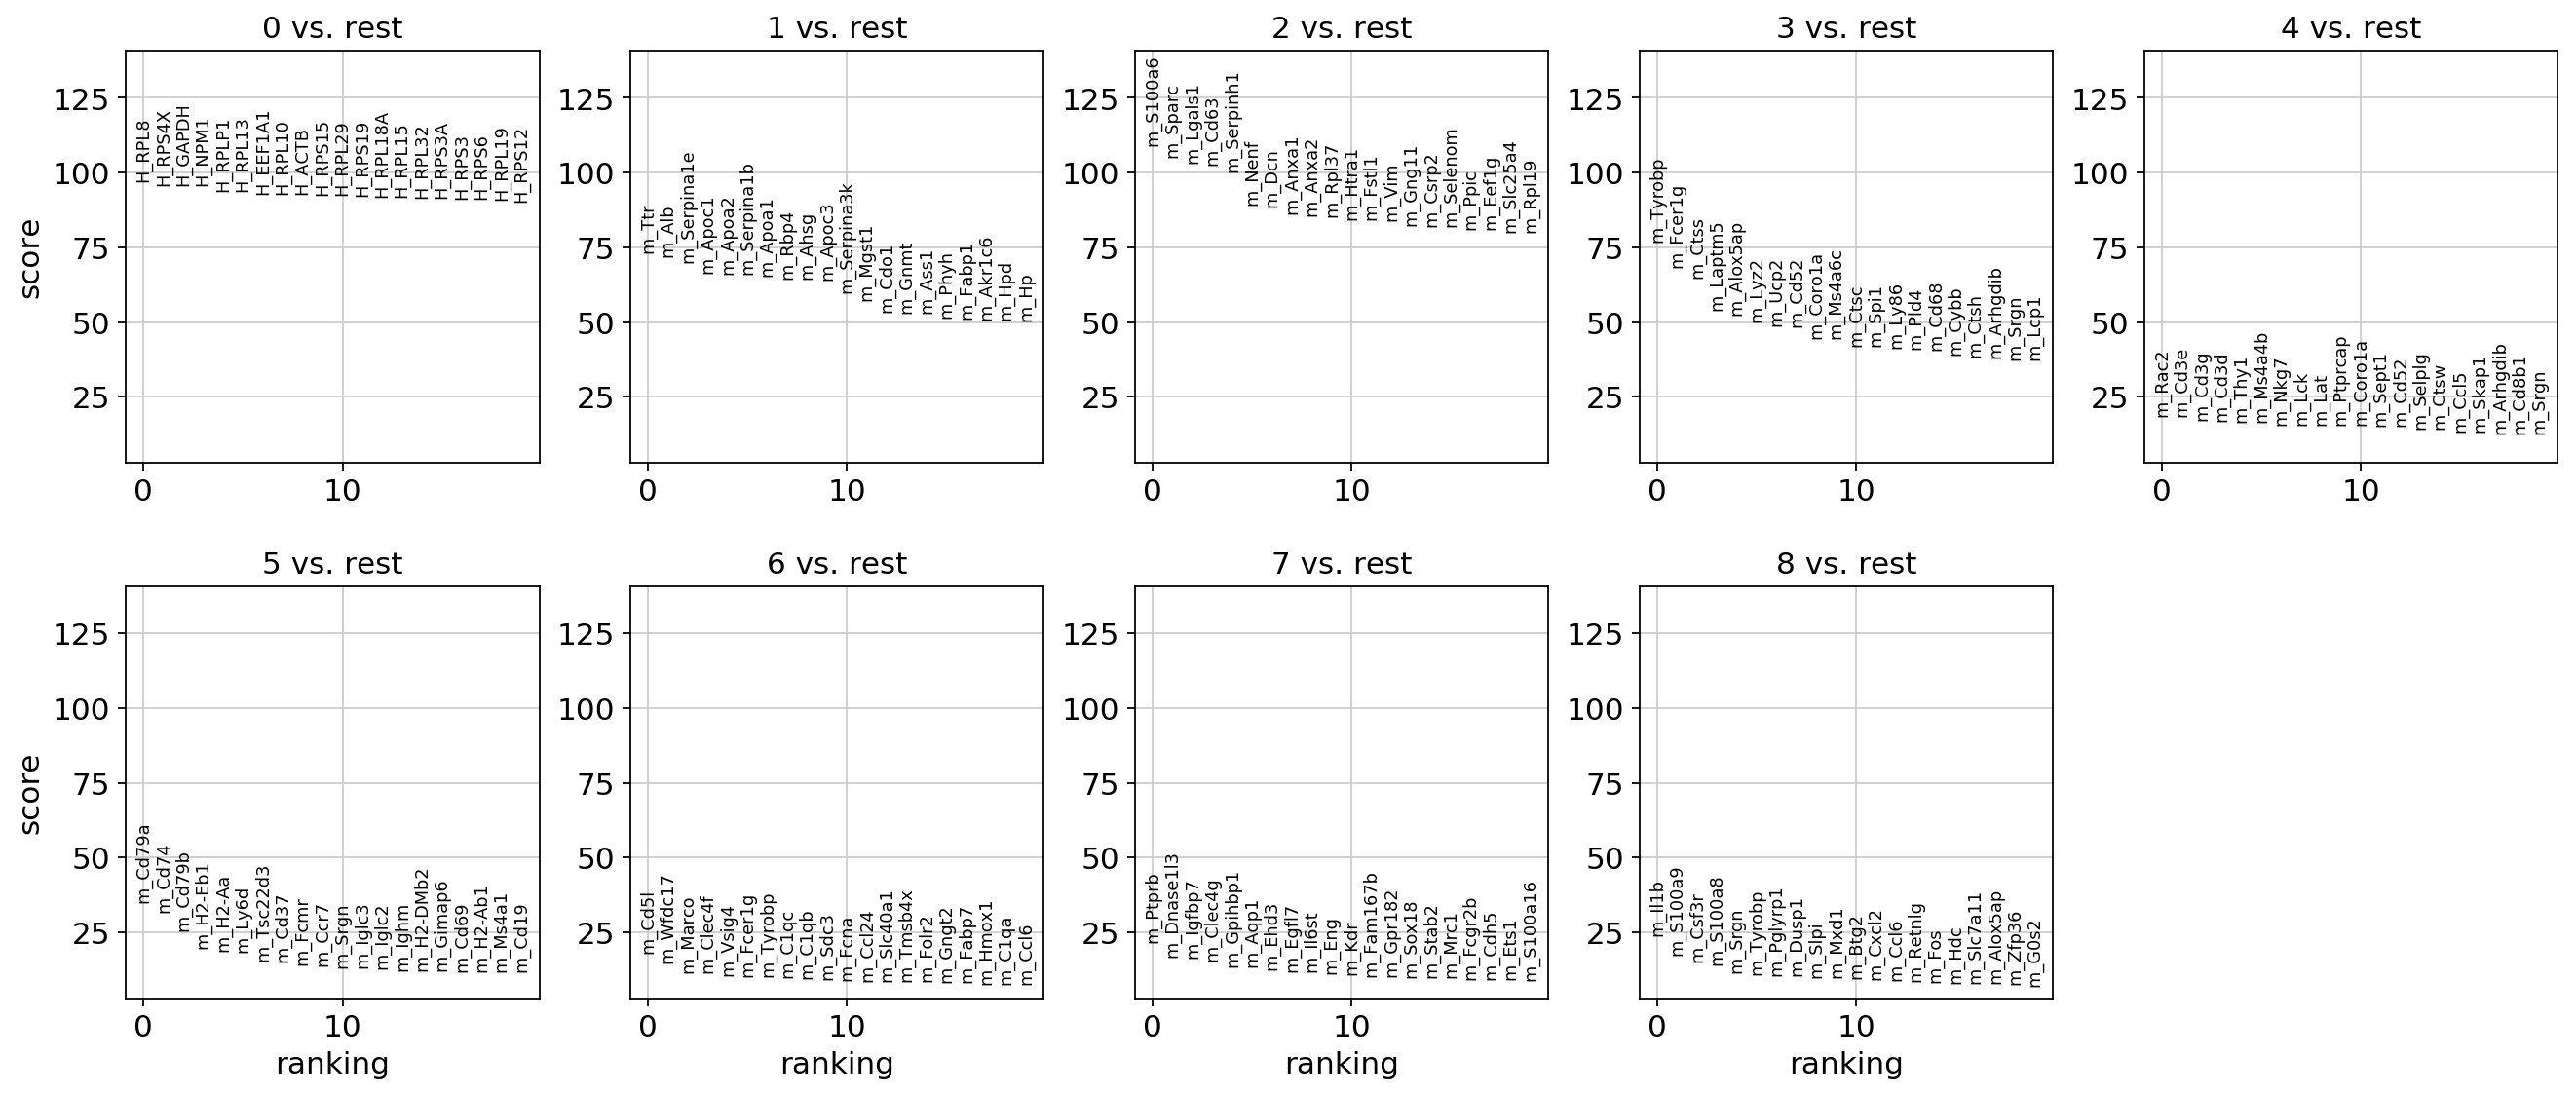

In [215]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(data['adata'], groupby='leiden', n_genes=100)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(data['adata'], ncols=5, n_genes=20)
sc.settings.verbosity = 4

In [216]:
genelist = data['adata'].uns['rank_genes_groups']['names'][str(0)][:50]
rank_genes = dict()
rank_genes[0] = genelist
for i in range(1, 9):
    print(rank_genes[i - 1].shape)
    common_genes = np.intersect1d(genelist, 
                                  data['adata'].uns['rank_genes_groups']['names'][str(i)][:50])
    rank_genes[i] = np.setdiff1d(data['adata'].uns['rank_genes_groups']['names'][str(i)][:50], common_genes)
    genelist = np.concatenate((genelist, rank_genes[i]))
print(rank_genes[i].shape)

(50,)
(50,)
(50,)
(50,)
(40,)
(38,)
(37,)
(46,)
(36,)


In [217]:
def make_df_from_enrichr(data):
    df = pd.DataFrame(data).set_index(0)
    df.drop([7, 8], axis=1, inplace=True)
    df.index.rename('rank', inplace=True)
    df.columns = ['term','p-value','odds ratio','combined score','genes','adjusted p-value']
    df = df[['term', 'genes','p-value']].copy()
    df['inverse p-value'] = df['p-value'].max() - df['p-value']
    return df

In [218]:
def enrichr(genelist, plot=True):
    
    def get_userListID(genelist):
        ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'
        genes_str = '\n'.join(genelist)
        description = 'Example gene list'
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        gene_list_response = requests.post(ENRICHR_URL, files=payload)
        if not gene_list_response.ok:
            raise Exception('Error analyzing gene list')

        data = json.loads(gene_list_response.text)
        userListID = data['userListId']
        return userListID
    
        
    libs = ['KEGG_2019_Mouse', 'Mouse_Gene_Atlas', 'WikiPathways_2019_Mouse', 
        'ARCHS4_Tissues', 'GO_Biological_Process_2018', 'GO_Molecular_Function_2018',
        'GO_Cellular_Component_2018']

    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    gsea_dict = dict()
    for lib in libs:
        response = requests.get(ENRICHR_URL + query_string % (get_userListID(genelist), lib))
        count = 0
        while not response.ok:
            count += 1
#             print('Request failed, retrieving new ID and retrying (%d/10) times...' % count)
            response = requests.get(ENRICHR_URL + query_string % (get_userListID(genelist), lib))
            if count == 10:
                break
            time.sleep(2)
        if not response.ok:
#             print("Request failed, moving to next reference library.")
            continue
#         print('Request succeeded.')
        response = json.loads(response.text)
        data = response[lib][:8]
        gsea_dict[lib] = make_df_from_enrichr(data)
    
    
    if plot == True:
        fig, ax = plt.subplots(1, len(libs), figsize=(30, 5))

        for lib, ax in zip(libs, np.ravel(ax)):
            gsea_dict[lib].plot.bar('term','inverse p-value', ax=ax, legend=None);
            ax.set_xlabel(None)
            ax.set_yscale('log')
            ax.get_yaxis().set_visible(False)
            xticks = ax.get_xticklabels()
            ax.set_xticklabels(xticks, ha='right', rotation=45, size=10);

        plt.show()
    
    return gsea_dict

In [219]:
# gsea_dicts = dict()
# for i in tqdm(range(1,12)):
#     print('Cluster %s' % str(i))
#     gsea_dicts[i] = dict()
#     done = False
#     while not done:
#         try:
#             gsea_dicts[i]['enrichr'] = enrichr(list(rank_genes[i]), plot=True)
#             done = True
#         except:
#             print('Connection reset, trying again.')
#             input()
#             continue
# #     gsea_dicts[i]['annotation'] = input() # ensure there is some time between the requests, else it will error

In [220]:
# gsea_dicts = {0: {'annotation': 'HEK293T'}, 
#               1: {'annotation': 'MC38 (Protein)'}, 
#               2: {'annotation': 'MC38 (mRNA)'}, 
#               3: {'annotation': 'MC38 (Adipose)'}, 
#               4: {'annotation': 'HEPATOCYTE (Glycolysis)'}, 
#               5: {'annotation': 'MPHAGE'}, 
#               6: {'annotation': 'BCELL'}, 
#               7: {'annotation': 'KUPFFER'}, 
#               8: {'annotation': 'HEPATOCYTE (Complement/Coagulation)'}, 
#              }

In [221]:
# ctdict = dict()
# for i in range(9):
#     ctdict[gsea_dicts[i]['annotation']] = [i]
    
# data['adata'].obs['celltype'] = data['adata'].obs['leiden']
# for ct in ctdict:
#     for clust in ctdict[ct]:
#         data['adata'].obs['celltype'].replace(r'^%s$' % str(clust), '10X_%s' % ct, regex=True, inplace=True)
# data['adata'].obs['celltype'] = data['adata'].obs['celltype'].astype('category')

In [222]:
# for i in data['adata'].uns['rank_genes_groups']['names']['8'][:10]:
#     print(i.strip('mm10___'))

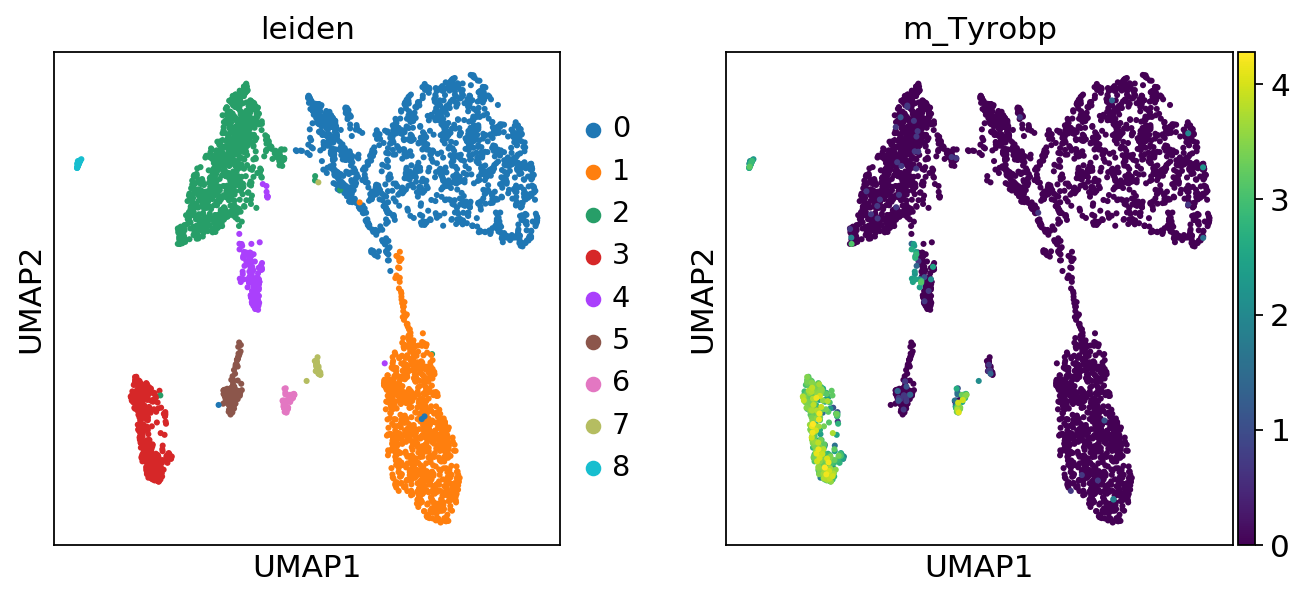

In [223]:
sc.pl.umap(data['adata'],color=['leiden', 'm_Tyrobp']);

In [224]:
ctdict = dict()
ctdict['HEK293T'] = [0]
ctdict['HEPATOCYTE'] = [1]
ctdict['MC38'] = [2]
ctdict['MPHAGE'] = [3]
ctdict['B'] = [5]
ctdict['KUPFFER'] = [6]
ctdict['LSEC'] = [7]
ctdict['GRANULOCYTE'] = [8]
ctdict['TCELL'] = [4]
data['adata'].obs['celltype2'] = data['adata'].obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        data['adata'].obs['celltype2'].replace(r'^%s$' % str(clust),'10X_%s' % ct,regex=True, inplace=True)
data['adata'].obs['celltype2'] = data['adata'].obs['celltype2'].astype('category')

In [225]:
colors

{'turq': '#8DD3C7',
 'dark yel': '#FFED6F',
 'light purp': '#BEBADA',
 'coral': '#FB8072',
 'blue': '#80B1D3',
 'orange': '#FDB462',
 'light gr': '#B3DE69',
 'purp': '#BC80BD',
 'pink': '#FCCDE5',
 'gray': '#D9D9D9',
 'mint': '#CCEBC5',
 'light yel': '#FFFFB3'}

In [226]:
data['adata'].uns['celltype2_colors'] = [
    colors['turq'],
    colors['pink'],
    colors['gray'],
    colors['coral'],
    colors['dark yel'],
    colors['light gr'],
    colors['blue'],
    colors['orange'],
    colors['purp'],
]

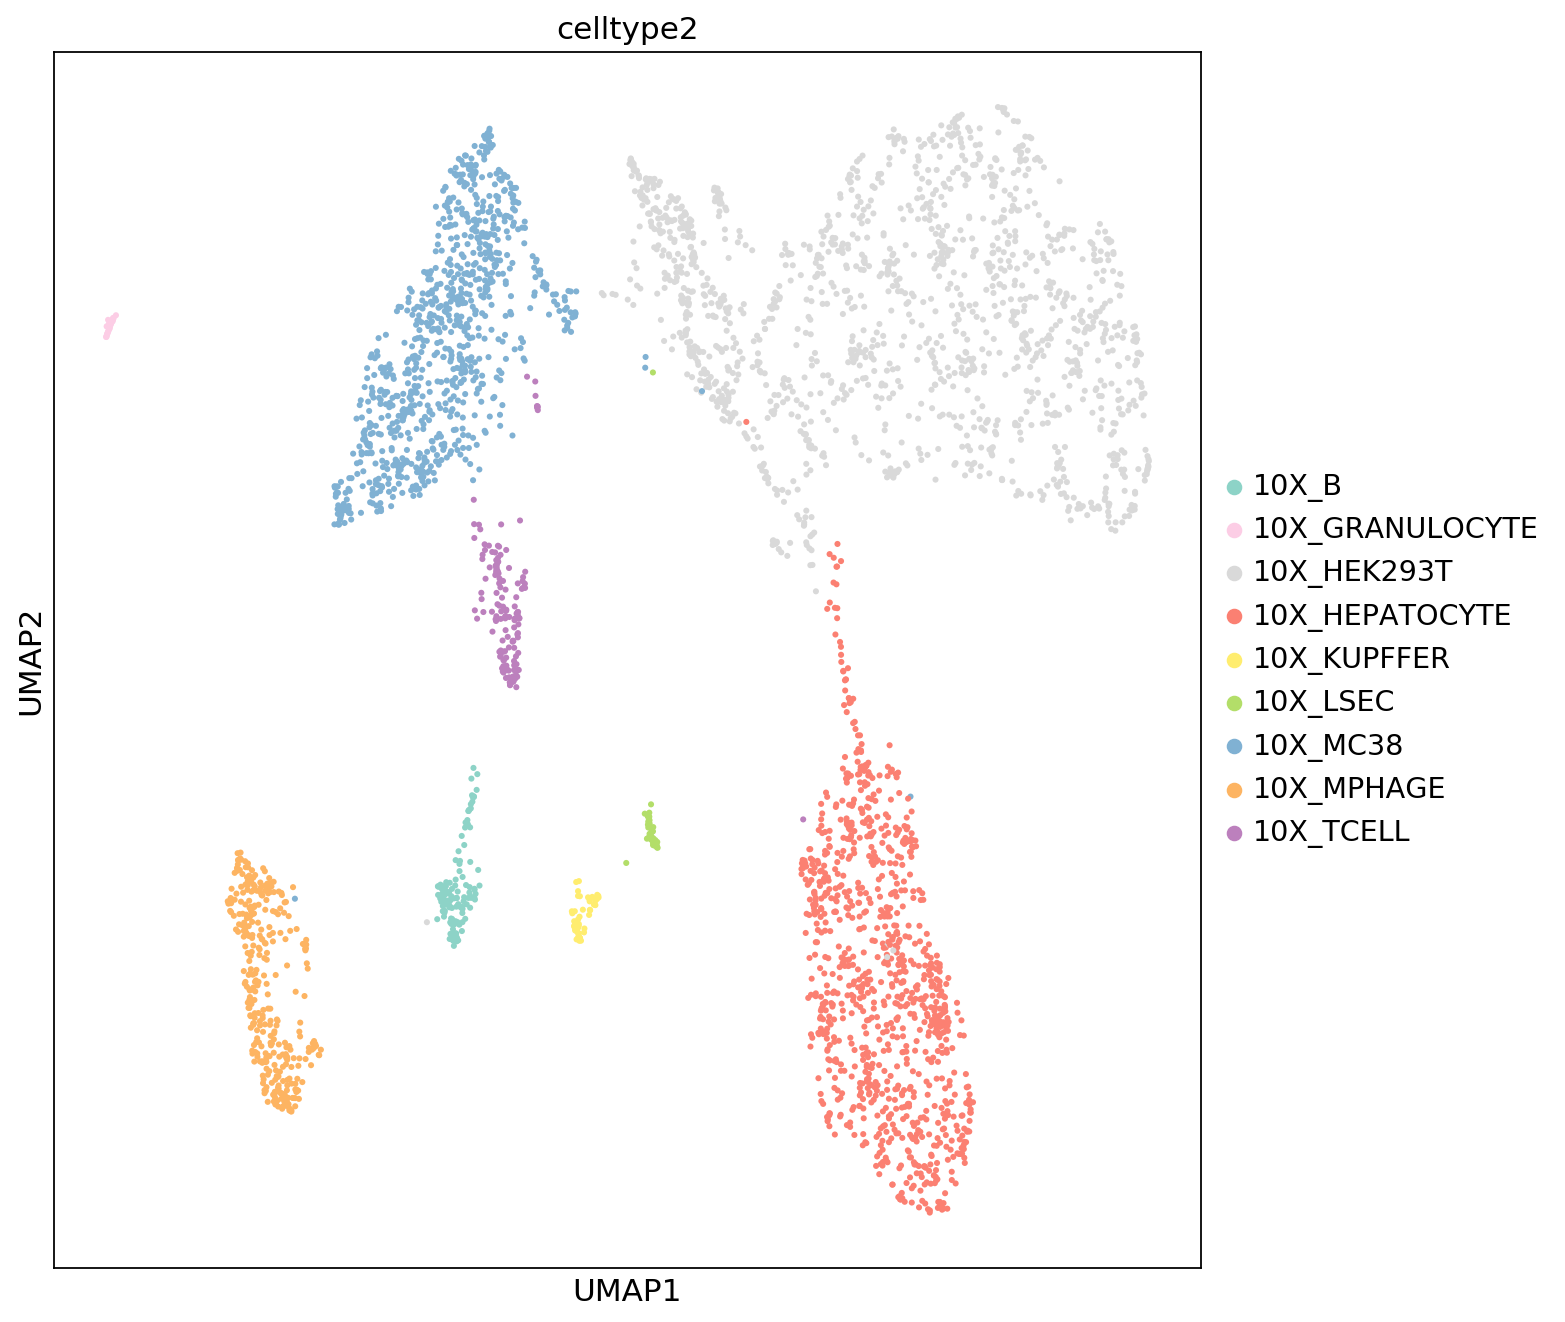

In [227]:
fig, ax = plt.subplots(1,1,figsize=(10, 8.5))
sc.pl.umap(data['adata'],color=['celltype2'], size=30, ax=ax, return_fig=False, show=False)
plt.tight_layout()
plt.savefig(prefix + '10x/2020112/figures2/10x.umap.pdf')

In [228]:
names, counts = np.unique(data['adata'].obs['celltype2'], return_counts=True)
for i in range(len(names)):
    print(names[i] + ": " + str(counts[i]/len(data['adata']))[:5])

10X_B: 0.032
10X_GRANULOCYTE: 0.008
10X_HEK293T: 0.359
10X_HEPATOCYTE: 0.240
10X_KUPFFER: 0.013
10X_LSEC: 0.011
10X_MC38: 0.210
10X_MPHAGE: 0.085
10X_TCELL: 0.037


### Violin Plots

First off, get the n_genes parameter in the `obs`.

In [ ]:
l20c1_raw.shape

In [ ]:
data['adata_original'] = data['adata_original'][data['adata'].obs_names,:].copy()

In [ ]:
sc.pp.filter_cells(data['adata_original'], min_genes=0)
sc.pp.filter_cells(l20c1_raw, min_genes=0)
sc.pp.filter_cells(data['adata_original'], min_counts=1)
sc.pp.filter_cells(l20c1_raw, min_counts=1)

I would like to plot a split violin, since it's cleaner and would save space.

In [ ]:
dfs_umis = list()
for adata, method in zip([l20c1_raw, data['adata_original']],['XYZeq', '10x']):
    umis = np.log10(adata.obs['n_counts'].values)
    dfs_umis.append(pd.DataFrame(zip(umis,
                                     [method]*len(adata)),
                                 columns = ['UMIs', 'Method']))

In [ ]:
dfs_genes = list()
for adata, method in zip([l20c1_raw, data['adata_original']],['XYZeq', '10x']):
    genes = np.log10(adata.obs['n_genes'].values)
    dfs_genes.append(pd.DataFrame(zip(genes,
                                      [method]*len(adata)),
                                  columns = ['Genes', 'Method']))

In [ ]:
violin_df_umis = pd.concat(dfs_umis)
violin_df_umis.index = range(len(violin_df_umis))

In [ ]:
violin_df_genes = pd.concat(dfs_genes)
violin_df_genes.index = range(len(violin_df_genes))

In [ ]:
# this is some hacky way to make the single variable show up split, see https://stackoverflow.com/questions/33745746/split-violinplot-in-seaborn-with-hue-parameter
violin_df_umis['all'] = "" 
violin_df_genes['all'] = ""

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
sns.violinplot(x="all", y="UMIs", data=violin_df_umis, hue='Method', split=True, ax=ax[0]);
ax[0].set_ylim(0,5.5);
ax[0].set_yticks(np.arange(0,5.75,0.25));
# ax[0].set_yscale('log')
sns.violinplot(x="all", y="Genes", data=violin_df_genes, hue='Method', split=True, ax=ax[1]);
ax[1].set_ylim(0,5.5);
ax[1].set_yticks(np.arange(0,5.75,0.25));
# ax[1].set_yscale('log')
plt.savefig(prefix + '10x/2020112/figures2/umi.gene.violins.pdf')

### Cell Type Correlations

Code taken from https://github.com/yelabucsf/lupus_1M_cells_clean/blob/master/figure6_flare/Figure6Flare.V6.ipynb

In [229]:
def marker_gene_expression(anndata, marker_dict, gene_symbol_key=None, partition_key='louvain_r1'):
    """A function go get mean z-score expressions of marker genes
    #
    # Inputs:
    #    anndata        - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or
    #                   an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker
    #                   genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                   'louvain_r1' """

    # Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names

    clusters = anndata.obs[partition_key].cat.categories
    n_clust = len(clusters)
    marker_exp = pd.DataFrame(columns=clusters)
    marker_exp['cell_type'] = pd.Series({}, dtype='str')
    marker_names = []

    z_scores = sc.pp.scale(anndata, copy=True)

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        for gene in marker_dict[group]:
            ens_idx = np.in1d(gene_ids, gene) #Note there may be multiple mappings
            if np.sum(ens_idx) == 0:
                continue
            else:
                z_scores.obs[ens_idx[0]] = z_scores.X[:,ens_idx].mean(1) #works for both single and multiple mapping
                ens_idx = ens_idx[0]

            clust_marker_exp = z_scores.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
            clust_marker_exp.append(group)
            marker_exp.loc[i] = clust_marker_exp
            marker_names.append(gene)
            i+=1

    # Replace the rownames with informative gene symbols
    marker_exp.index = marker_names

    return(marker_exp)

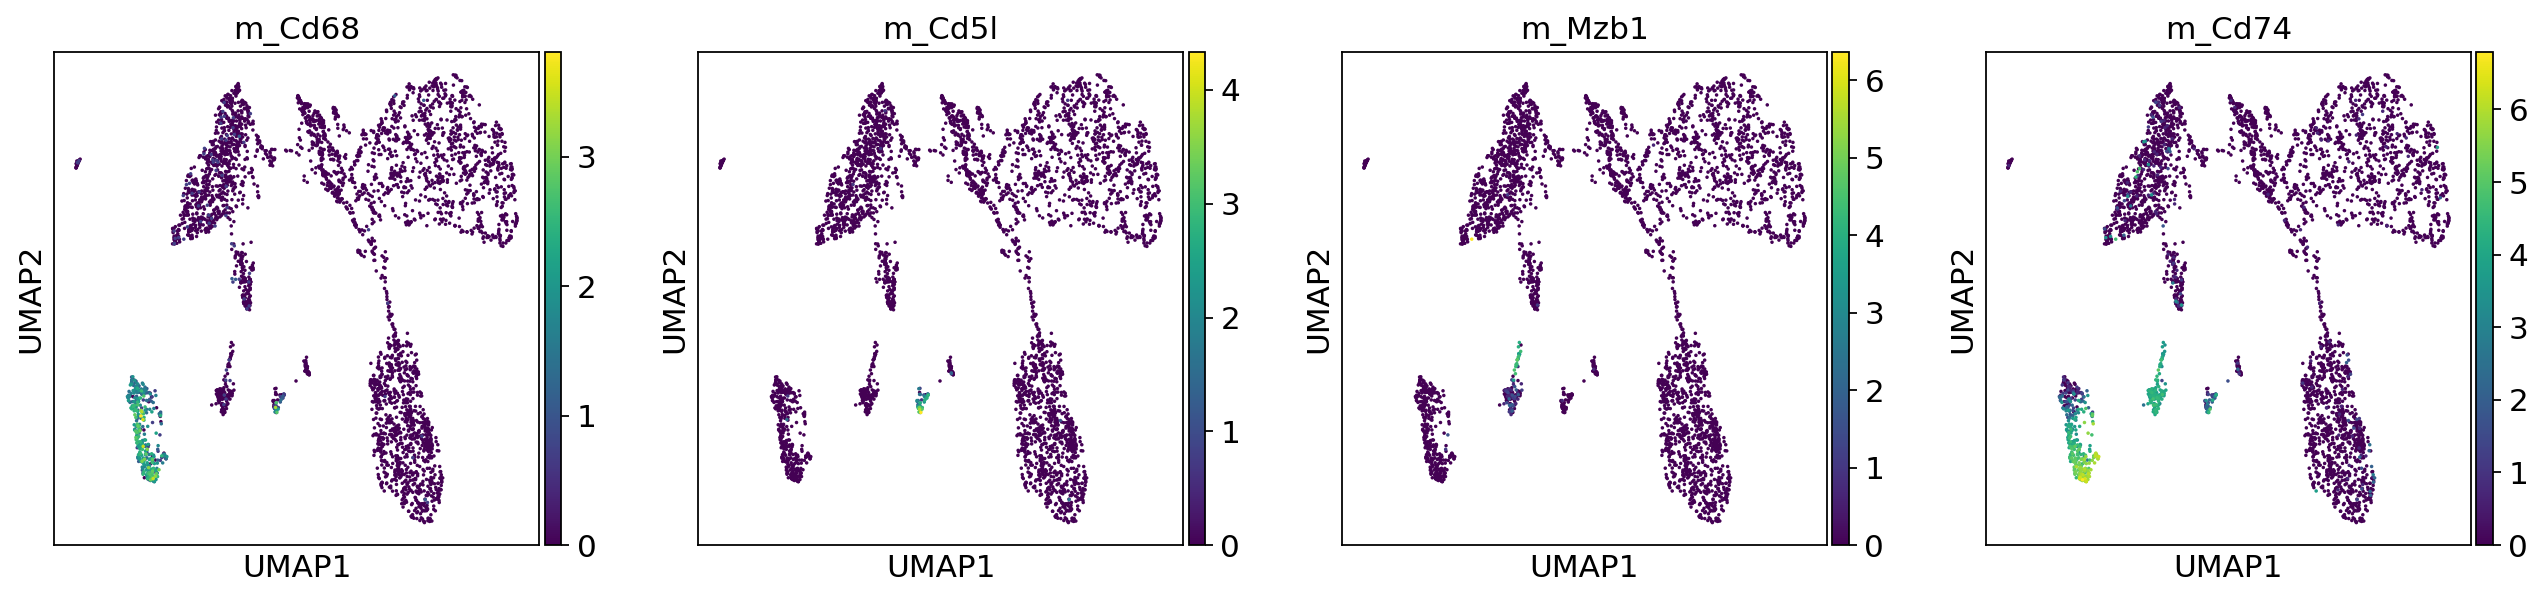

In [230]:
sc.pl.umap(data['adata'],color=['m_Cd68', 'm_Cd5l', 'm_Mzb1', 'm_Cd74'], size=10)

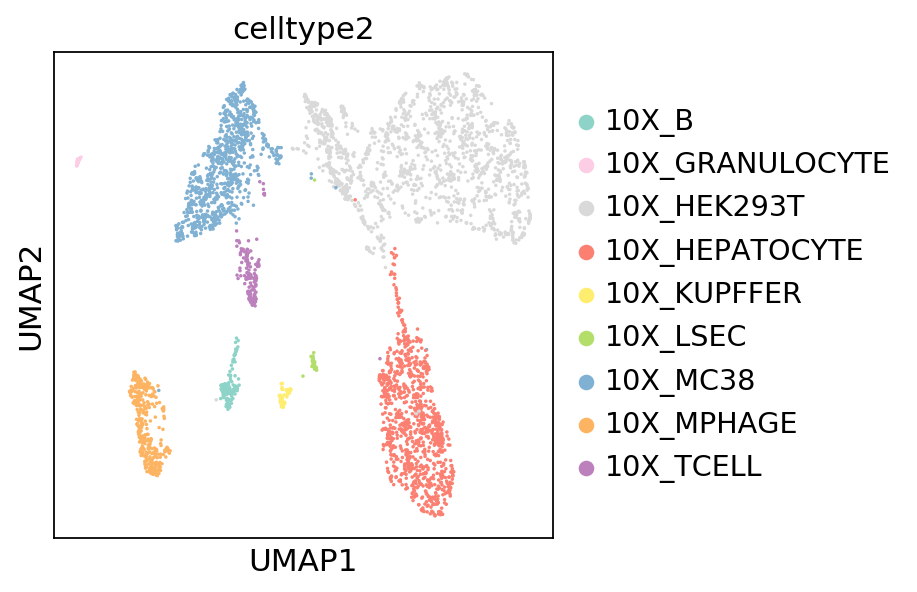

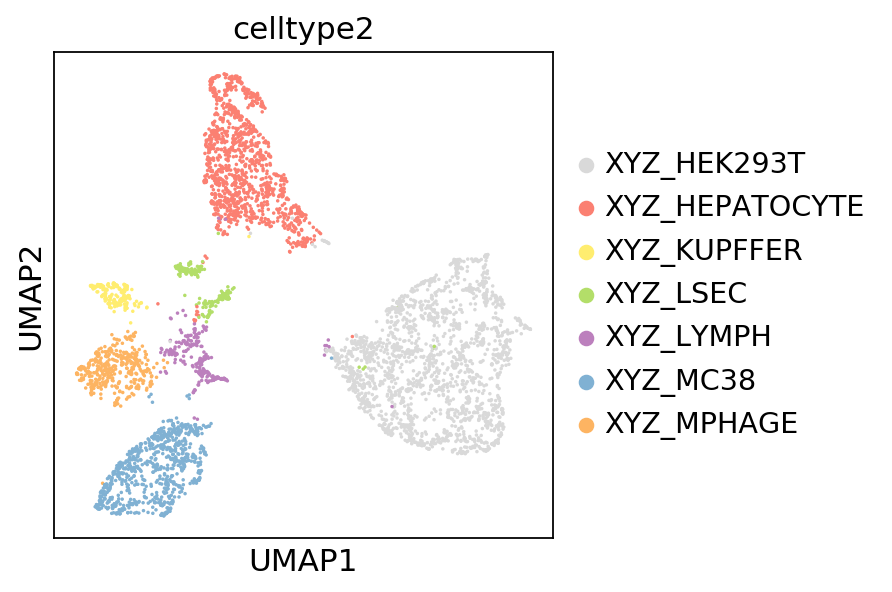

In [231]:
sc.pl.umap(data['adata'],color=['celltype2'], size=10)
sc.pl.umap(l20c1,color=['celltype2'], size=10)

In [232]:
names, counts = np.unique(l20c1.obs['celltype2'], return_counts=True)
for i in range(len(names)):
    print(names[i] + ": " + str(counts[i]/len(l20c1))[:5])

XYZ_HEK293T: 0.378
XYZ_HEPATOCYTE: 0.250
XYZ_KUPFFER: 0.037
XYZ_LSEC: 0.041
XYZ_LYMPH: 0.049
XYZ_MC38: 0.160
XYZ_MPHAGE: 0.082


In [233]:
# data['adata'].write_h5ad(prefix + '/10x/5prime_liver/10x.dimred.h5ad')
# l20c1.write_h5ad(prefix + '/10x/5prime_liver/l20c1.dimred.h5ad')

In [234]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(l20c1, groupby='celltype2', n_genes=1000)
sc.tl.rank_genes_groups(data['adata'], groupby='celltype2', n_genes=1000)
warnings.filterwarnings('default')
sc.settings.verbosity = 4

In [235]:
data['adata']

AnnData object with n_obs × n_vars = 4027 × 68 
    obs: 'n_counts', 'n_genes', 'percent_mito', 'mouse_counts', 'human_counts', 'ratio', 'cell_call', 'leiden', 'louvain', 'CellType', 'celltype', 'celltype2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'CellType_colors', 'cell_call_colors', 'leiden', 'leiden_colors', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'celltype2_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [236]:
cts = data['adata'].obs['celltype2'].unique()
genes = np.concatenate([data['adata'].uns['rank_genes_groups']['names'][ct][:100] for ct in cts])
genes = np.unique(genes)
genes = np.intersect1d(genes, l20c1.var_names.values)
# genes = np.intersect1d(data['adata'].var_names.values, l20c1.var_names.values)

In [253]:
genes.shape

(115,)

In [238]:
marker_dictionary = pd.DataFrame({"all": genes})

In [239]:
l20c1_unscaled = sc.read_h5ad(l20c1_prefix + 'adata.4.h5ad')

In [240]:
l20c1_unscaled = l20c1_unscaled[l20c1.obs_names].copy()
data['adata_unscaled'] = data['adata'].raw._adata.copy()

In [241]:
data['adata_unscaled'].obs['celltype2'] = data['adata'].obs['celltype2'].values
l20c1_unscaled.obs['celltype2'] = l20c1.obs['celltype2'].values

In [242]:
new_names = list()
for i in l20c1_unscaled.var_names:
    if i.startswith('hg19_'):
        new_names.append('H_' + i[5:])
    else:
        new_names.append('m_' + i[5:])
l20c1_unscaled.var_names = new_names

In [243]:
marker_exp_10x = marker_gene_expression(data['adata_unscaled'], marker_dictionary, partition_key="celltype2")

In [244]:
marker_exp_XYZeq = marker_gene_expression(l20c1_unscaled, marker_dictionary, partition_key="celltype2")

In [245]:
exp_result = pd.concat([marker_exp_10x, marker_exp_XYZeq], axis=1, join='inner')

In [246]:
exp_result.columns

Index(['10X_B', '10X_GRANULOCYTE', '10X_HEK293T', '10X_HEPATOCYTE',
       '10X_KUPFFER', '10X_LSEC', '10X_MC38', '10X_MPHAGE', '10X_TCELL',
       'cell_type', 'XYZ_HEK293T', 'XYZ_HEPATOCYTE', 'XYZ_KUPFFER', 'XYZ_LSEC',
       'XYZ_LYMPH', 'XYZ_MC38', 'XYZ_MPHAGE', 'cell_type'],
      dtype='object')

In [247]:
exp_result = exp_result[['10X_MC38', '10X_HEPATOCYTE', '10X_KUPFFER', '10X_LSEC', '10X_MPHAGE','10X_B', '10X_TCELL', '10X_GRANULOCYTE',
                         'XYZ_MC38', 'XYZ_HEPATOCYTE', 'XYZ_KUPFFER', 'XYZ_LSEC', 'XYZ_MPHAGE', 'XYZ_LYMPH']]

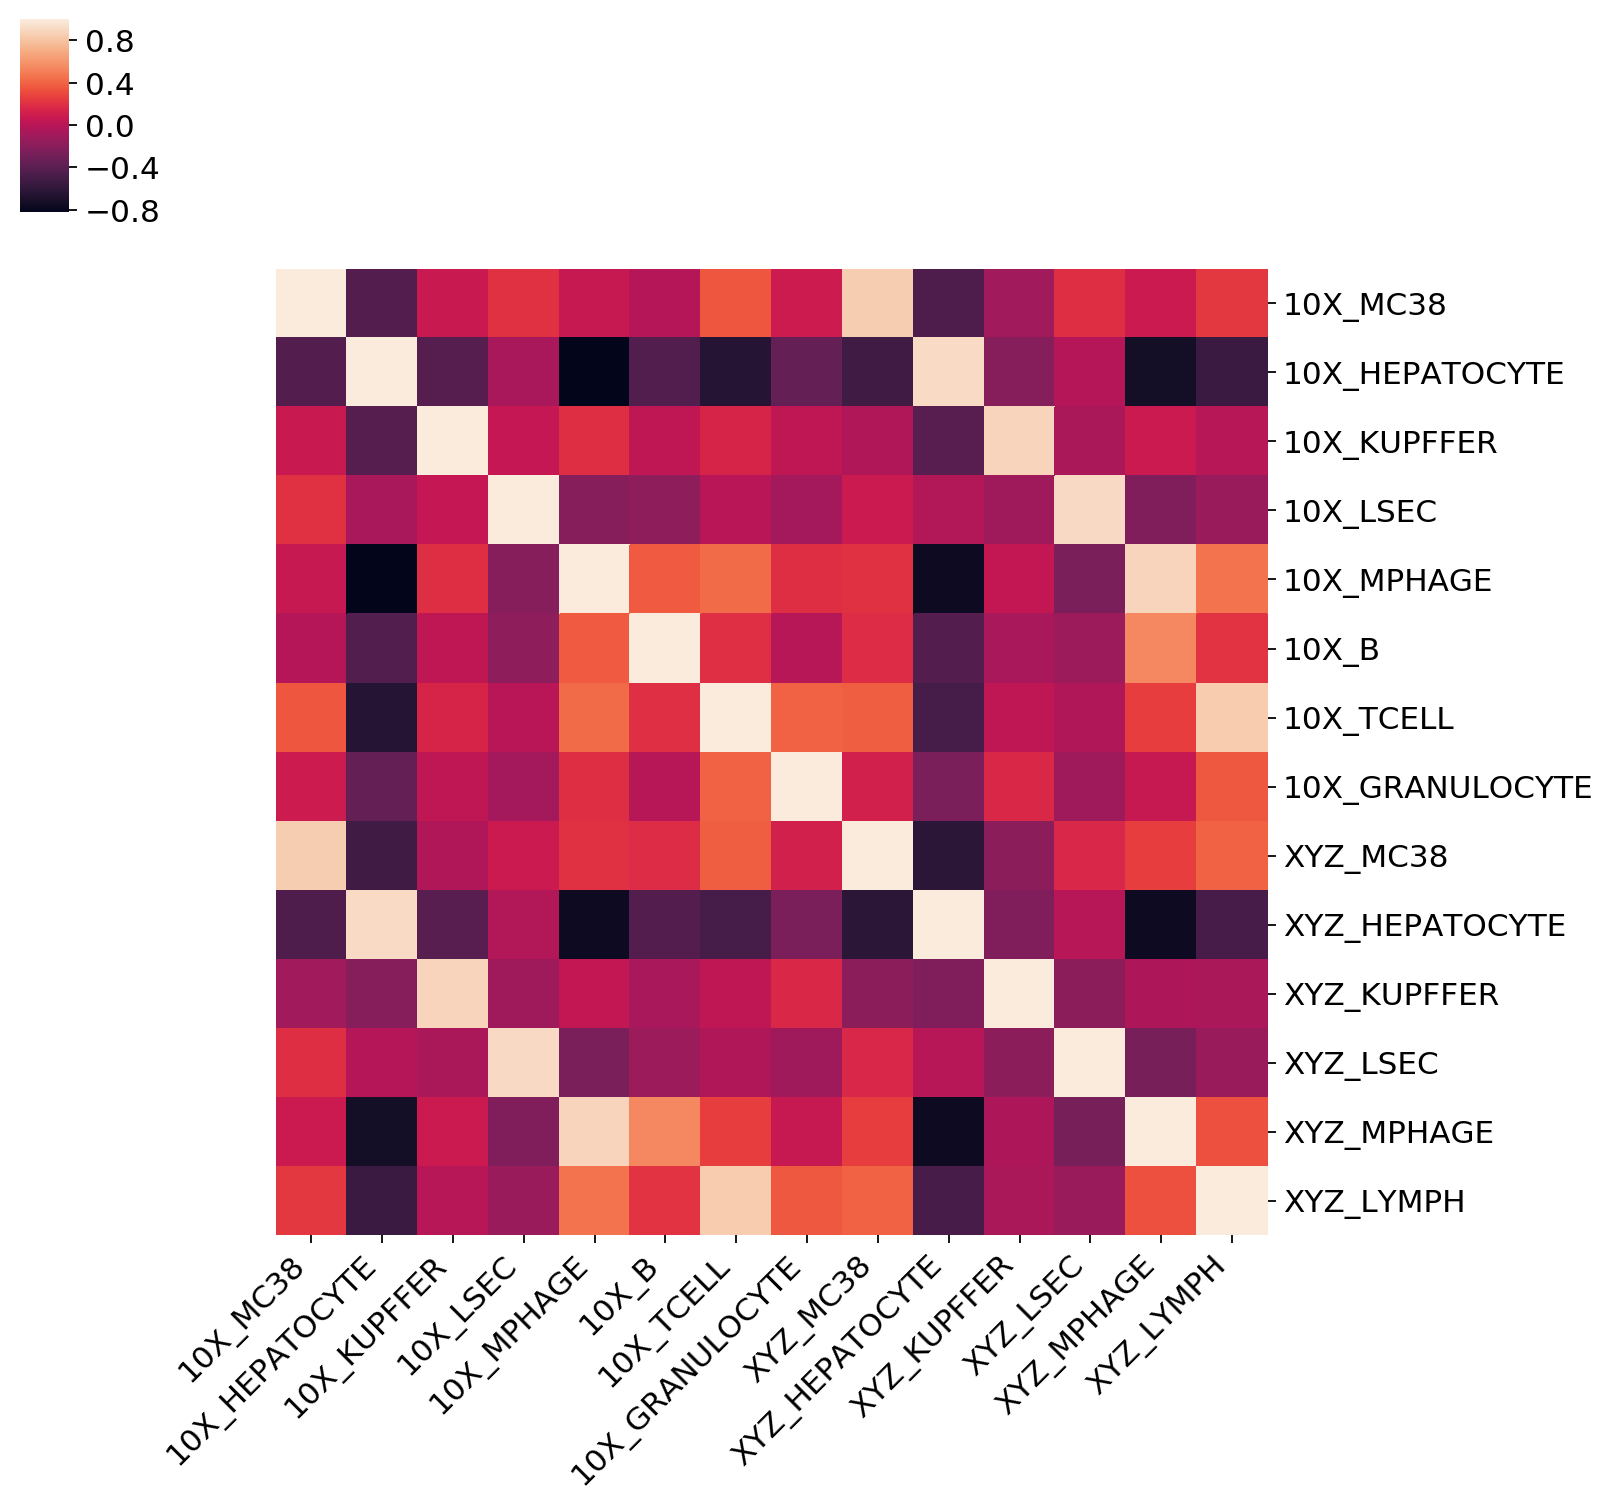

In [248]:
exp_corr = exp_result.corr()
exp_corr.style.background_gradient(cmap='coolwarm').set_precision(2)
# fig, ax = plt.subplots(1,1,figsize=(10,10))
g = sns.clustermap(exp_corr, yticklabels=True, xticklabels=True, row_cluster=False, col_cluster=False);
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right');
# g.savefig(prefix + '10x/2020112/figures2/10x.L20C1.ct.heatmap.pdf')

### Read in Ingested Data from Derek

Again, here I resort to using this, but I'm very reluctant to and I don't think this is publishable work. This projection is based on only 60 genes, very few (if any) of which show up as differentially expressed genes if analyzed independently.

In [343]:
adata = sc.read_loom(prefix + '10x/5prime_liver/20200112/L20C1_10X_concat.loom')

/home/ghartoularos/anaconda3/envs/xyzeq/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [344]:
adata

AnnData object with n_obs × n_vars = 8815 × 683 
    obs: 'CellType', 'barcode', 'batch', 'cell_call', 'human_counts', 'leiden', 'log_counts', 'mouse_counts', 'n_counts', 'n_genes', 'percent_contam', 'percent_mito', 'percent_mito_human', 'percent_mito_mouse', 'prox_1', 'prox_2', 'ratio', 'tissue'
    var: 'feature_types-10X', 'gene_ids-10X', 'genome-10X', 'log_cells-XYZeq', 'n_cells-10X', 'n_cells-XYZeq'
    obsm: 'X_pca', 'X_umap'

In [345]:
sc.pp.pca(adata,n_comps=100)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
        as `zero_center=True`, sparse input is densified and may lead to huge memory consumption
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


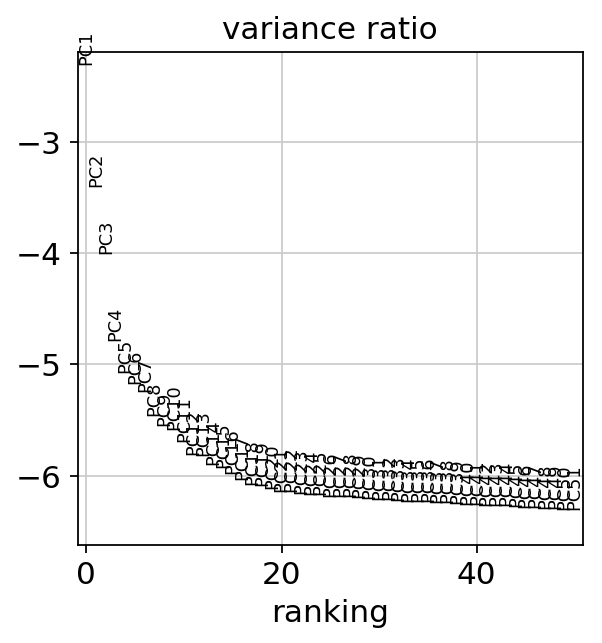

In [346]:
sc.pl.pca_variance_ratio(adata,log=True, n_pcs=50)

In [347]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 20
    computed neighbors (0:00:04)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:06)


In [348]:
sc.tl.leiden(adata,resolution=1.5)

running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


... storing 'CellType' as categorical
... storing 'barcode' as categorical
... storing 'batch' as categorical
... storing 'cell_call' as categorical
... storing 'tissue' as categorical
... storing 'feature_types-10X' as categorical
... storing 'genome-10X' as categorical


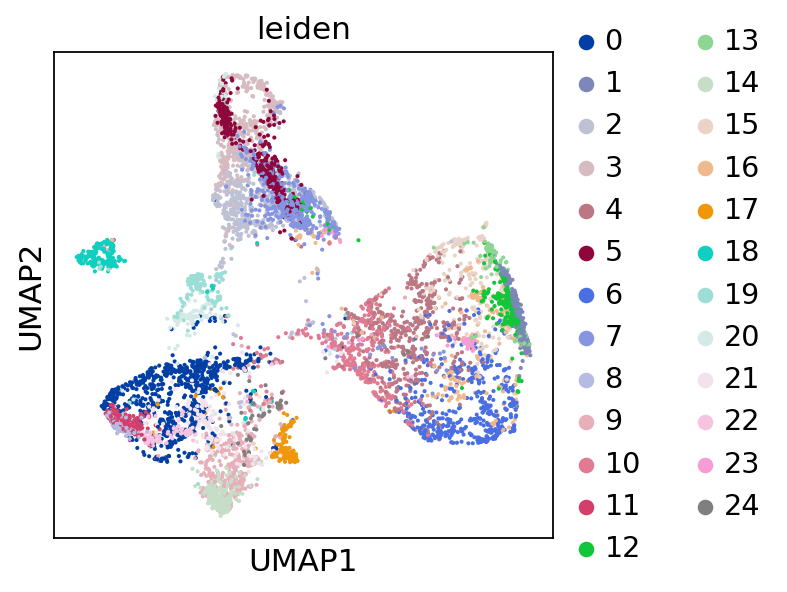

In [349]:
sc.pl.umap(adata,color=['leiden'], palette=sc.pl.palettes.default_26)

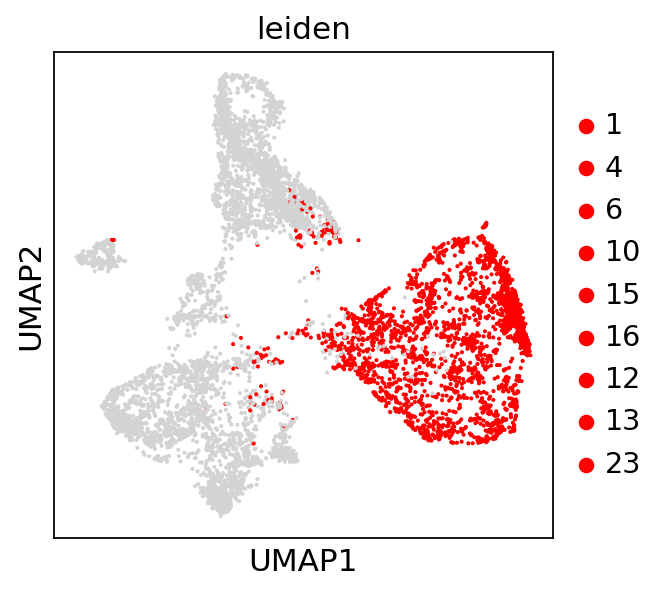

In [350]:
highlight = [1, 4, 6, 10, 15, 16, 12, 13, 23]
sc.pl.umap(adata,color=['leiden'], groups=[str(i) for i in highlight], palette=['red'])

In [351]:
ctdict = dict()

ctdict['ct0'] = [0, 11, 22, 8, 21]
ctdict['ct1'] = [1, 4, 6, 10, 15, 16, 12, 13, 23]
ctdict['ct2'] = [9, 14, 24]
ctdict['ct3'] = [17]
ctdict['ct4'] = [19, 20]
ctdict['ct5'] = [18]
ctdict['ct6'] = [2, 3, 5, 7]

adata.obs['celltype'] = adata.obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        adata.obs['celltype'].replace(r'^%s$' % str(clust), ct, regex=True, inplace=True)
adata.obs['leiden'] = [i.strip('ct') for i in adata.obs['celltype'].astype('category')]

... storing 'leiden' as categorical
... storing 'celltype' as categorical


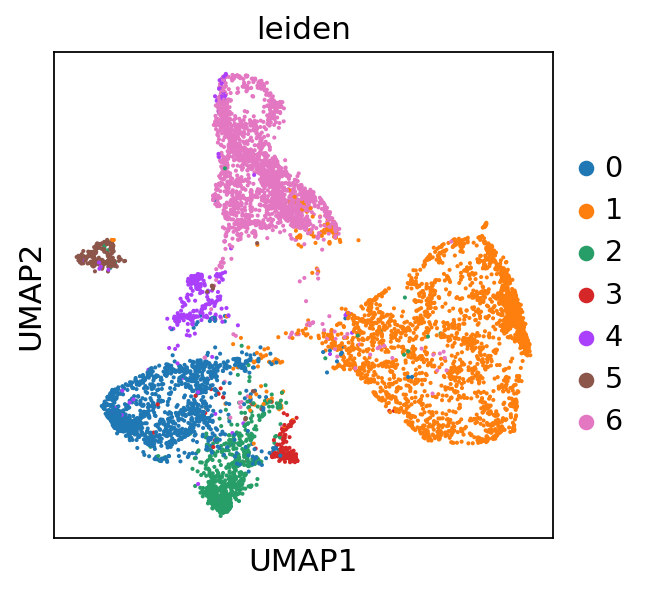

In [352]:
sc.pl.umap(adata,color=['leiden'], palette=sc.pl.palettes.default_20)

### Correlate proportion in each Leiden cluster

In [353]:
groups = adata.obs['leiden'].unique()

In [354]:
group_counts = list()
for group in groups: # groups defined earlier
    batches = adata[adata.obs['leiden'] == group].obs['batch'].values
    vals, counts = np.unique(batches, return_counts=True)
    group_counts.append(counts)

In [355]:
vals, batch_counts = np.unique(adata.obs['batch'].values, return_counts=True)

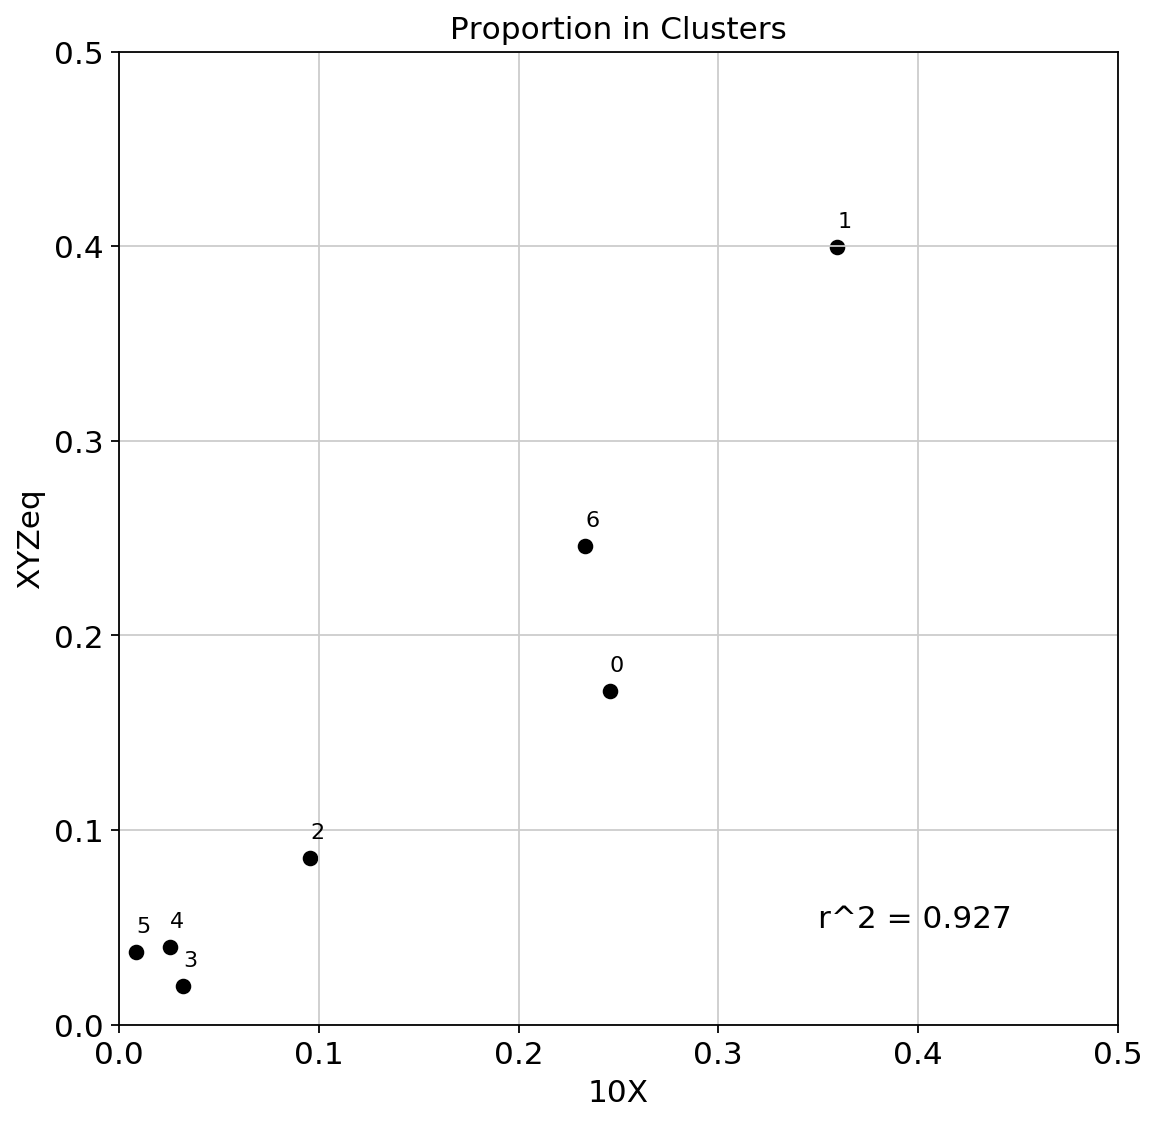

In [357]:
x = [i[0]/batch_counts[0] for i in group_counts]
y = [i[1]/batch_counts[1] for i in group_counts]
n = groups

plt.figure(figsize=(8,8))
plt.scatter(x, y, color='k');
plt.title('Proportion in Clusters')
plt.xlabel('%s' % vals[0])
plt.ylabel('%s' % vals[1])
plt.xlim(0,0.5)
plt.xticks(np.arange(0, 0.6, 0.1))
plt.ylim(0,0.5)
ax = plt.gca()
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]+0.01), size=10)

# The difference between correlation and coefficient of determination
# They can correlate, but that's not what I want to see. I want to see how well they fit the model that the proportions should be identical, x = y
# is the r2_score() command right then?

# r = pearsonr(x,y)[0]
r2 = r2_score(y_true=y, y_pred=x)

# plt.text(0.2, 0.01, 'pearsonr = ' + str(r)[:5]);
plt.text(0.35, 0.05, 'r^2 = ' + str(r2)[:5]);
plt.savefig(prefix + '10x/2020112/figures2/correlate.proportion.pdf')

## Make Bubble Plot

Define the genes we want to look at in the bubble plot.

In [358]:
new_names = list()
for i in adata.var_names:
    if i.startswith('GRCh38_'):
        new_names.append('H_' + i[7:])
    else:
        new_names.append('m_' + i[7:])
adata.var_names = new_names

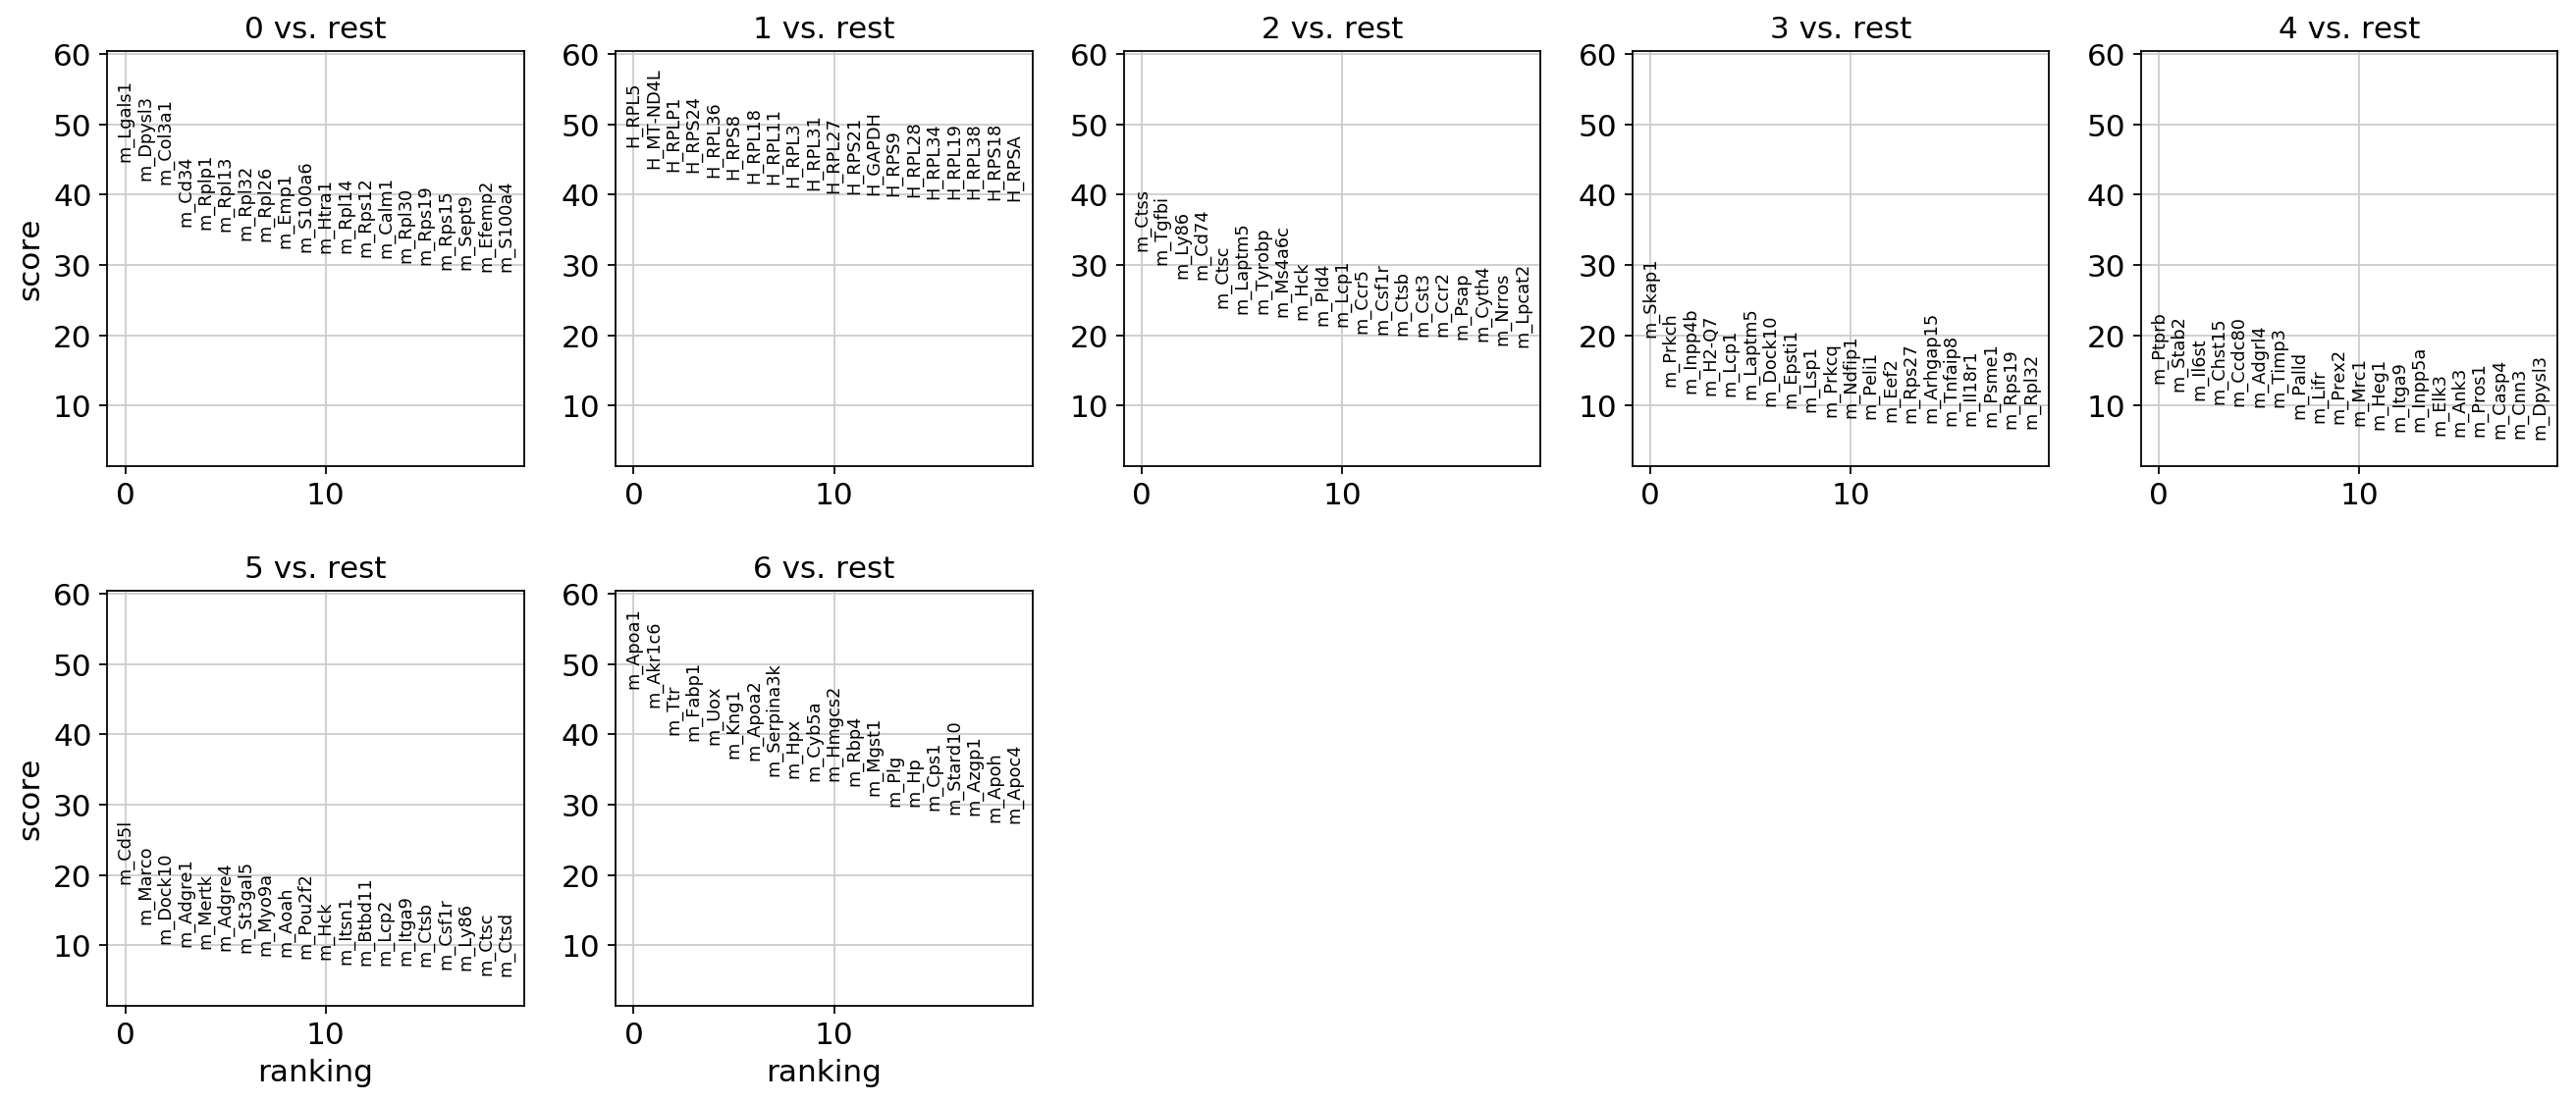

In [359]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(adata, groupby='leiden')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(adata, ncols=5)
sc.settings.verbosity = 4

In [360]:
ctdict = dict()

ctdict['MC38'] = [0]
ctdict['HEK293T'] = [1]
ctdict['MPHAGE'] = [2]
ctdict['LYMPH'] = [3]
ctdict['LSEC'] = [4]
ctdict['KUPFFER'] = [5]
ctdict['HEP'] = [6]

adata.obs['celltype'] = adata.obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        adata.obs['celltype'].replace(r'^%s$' % str(clust), ct, regex=True, inplace=True)
# adata.obs['celltypes'] = [i.strip('ct') for i in adata.obs['celltype'].astype('category')]

... storing 'celltype' as categorical


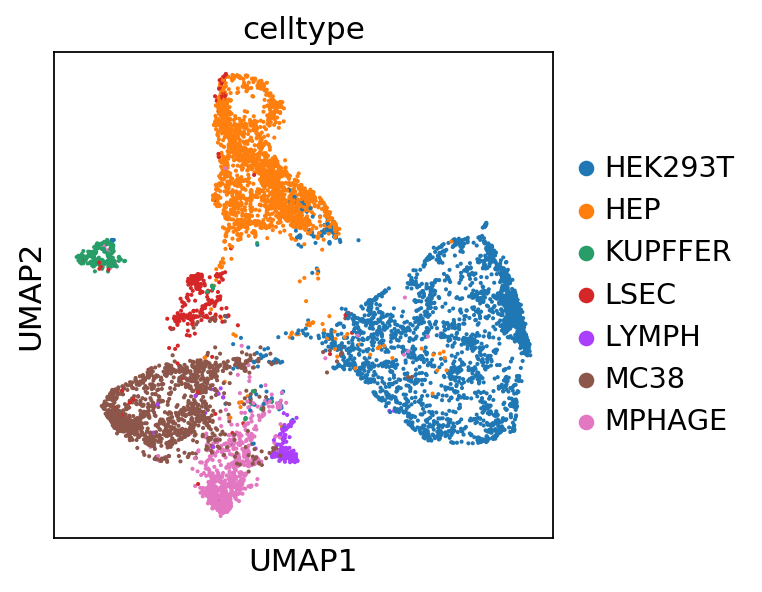

In [361]:
sc.pl.umap(adata,color=['celltype'], palette=sc.pl.palettes.default_20)

In [362]:
adata.uns['celltype_colors'] = [
    colors['gray'],
    colors['coral'],
    colors['dark yel'],
    colors['light gr'],
    colors['purp'],
    colors['blue'],
    colors['orange']
]

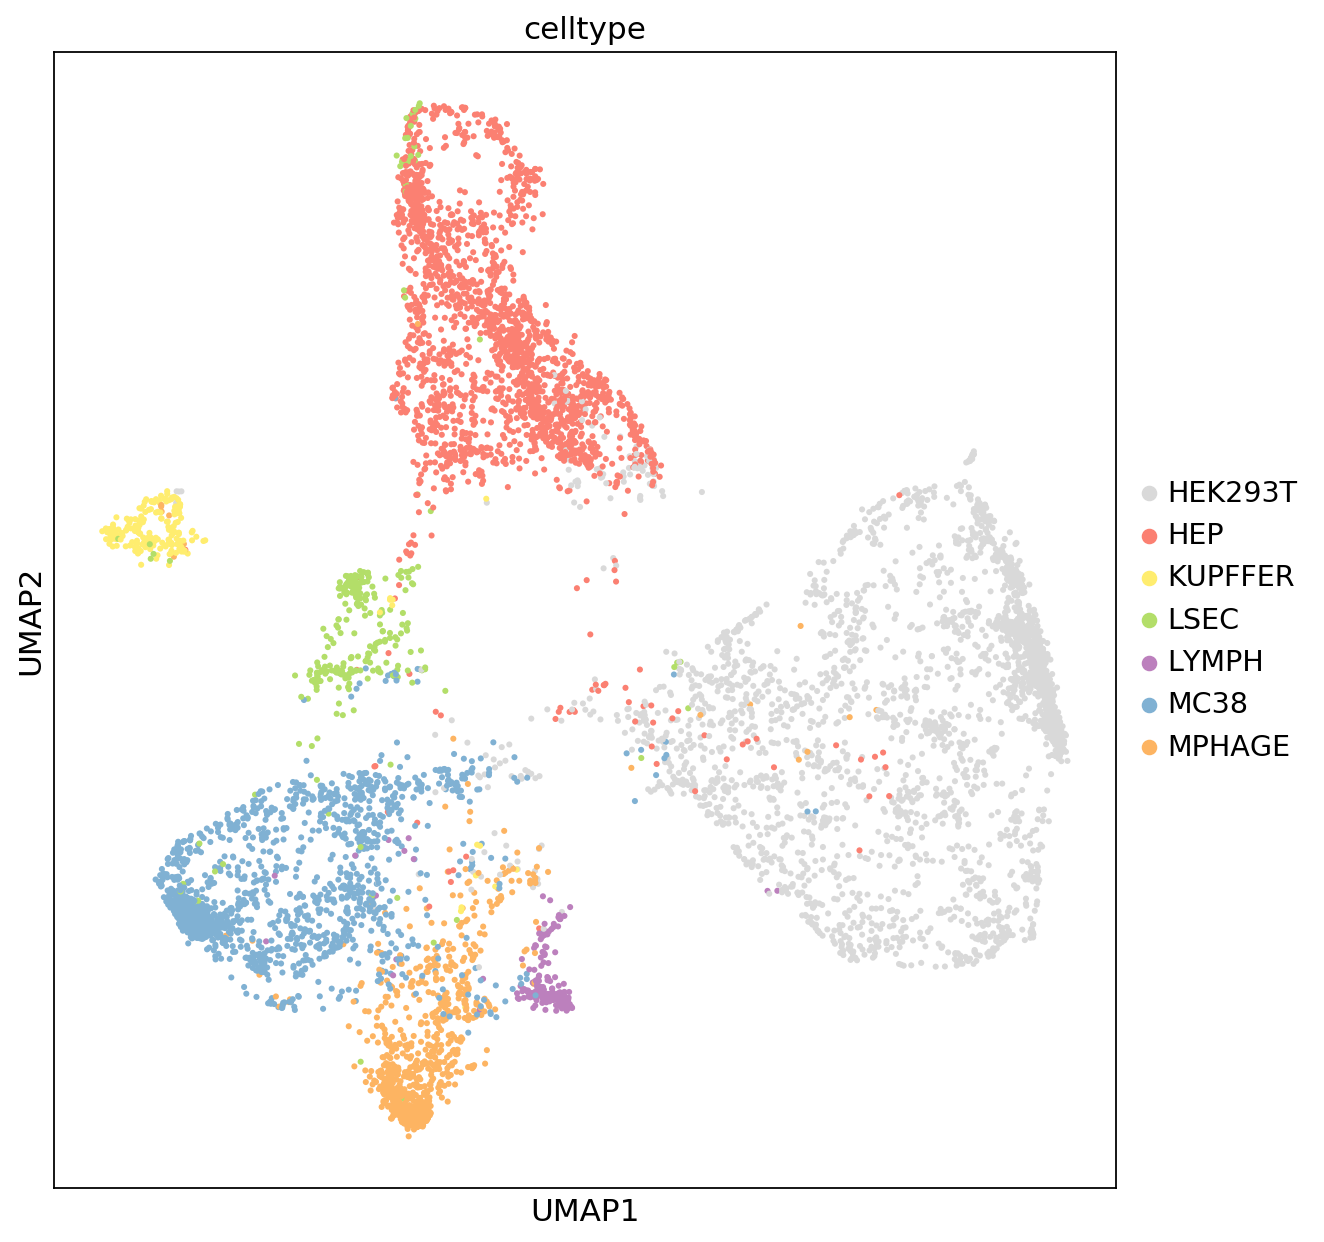

In [363]:
fig, ax = plt.subplots(1,1,figsize=(8.5, 8))
sc.pl.umap(adata,color=['celltype'], size=30, ax=ax, return_fig=False, show=False)
plt.tight_layout()
plt.savefig(prefix + '10x/2020112/figures2/10x.l20c1.joint.umap.pdf')

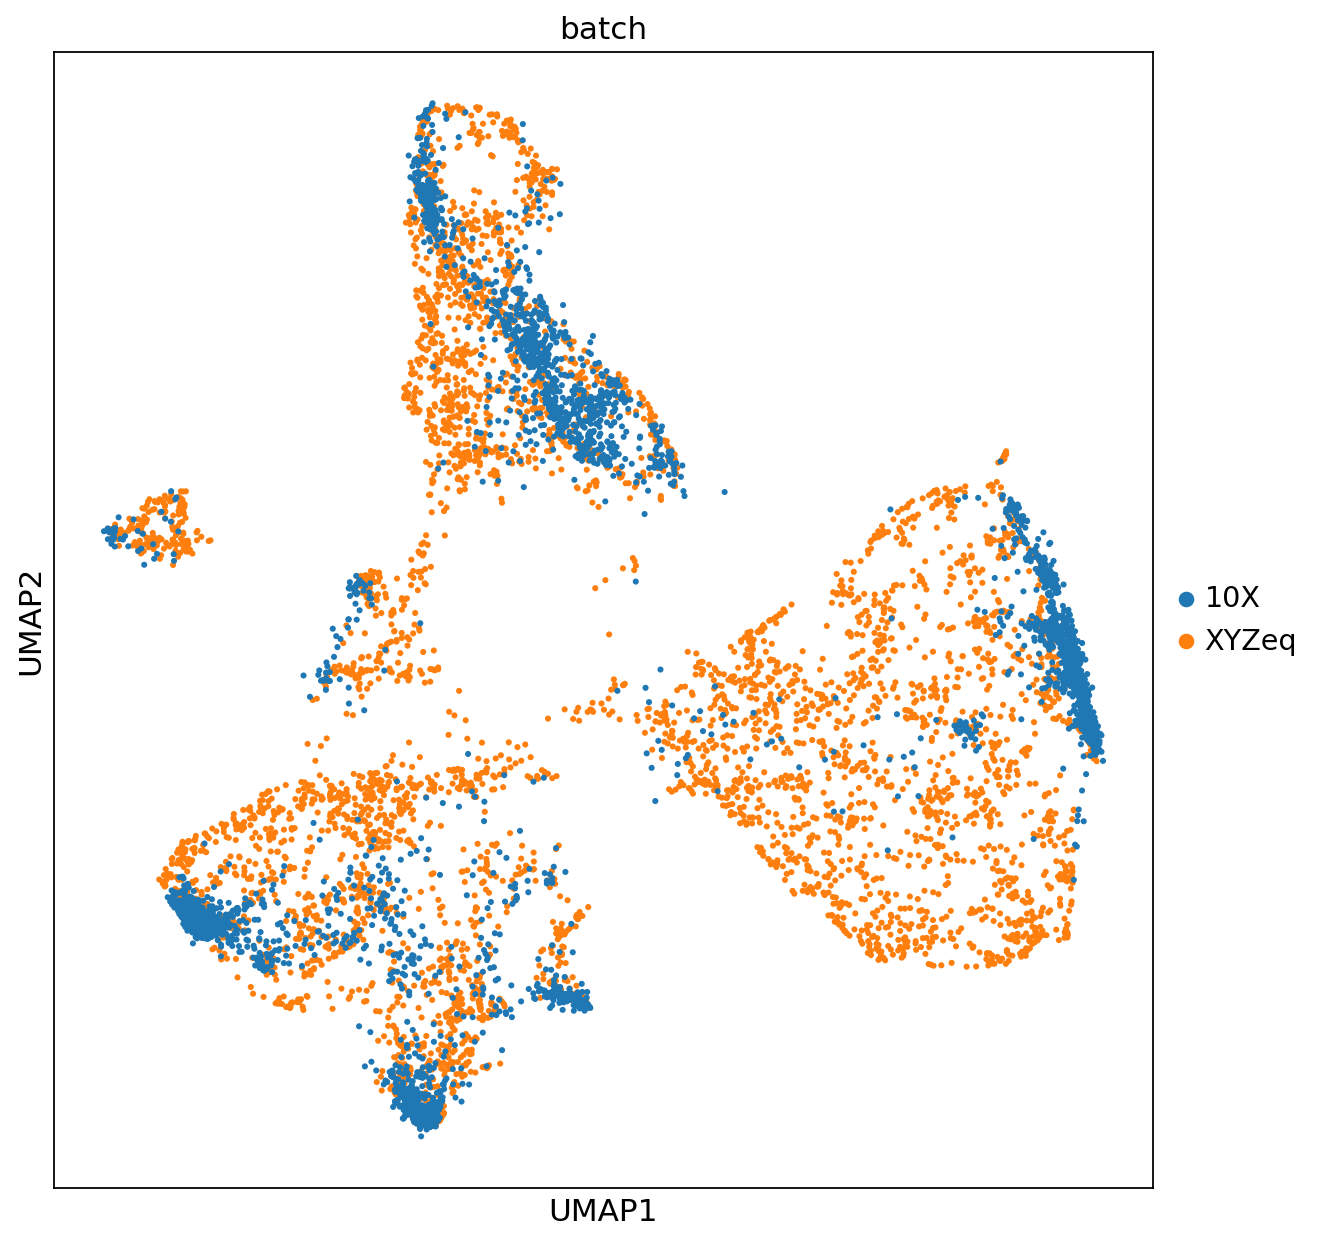

In [364]:
fig, ax = plt.subplots(1,1,figsize=(8.5, 8))
sc.pl.umap(adata,color=['batch'], size=30, ax=ax, return_fig=False, show=False)
plt.tight_layout();
plt.savefig(prefix + '10x/2020112/figures2/10x.l20c1.joint.batch.umap.pdf')

In [365]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(adata, groupby='celltype')
warnings.filterwarnings('default')
sc.settings.verbosity = 4

In [366]:
genes = dict()
cts = ['HEP', 'LSEC', 'MC38', 'KUPFFER', 'MPHAGE', 'LYMPH']
for ct in cts: # good order for visualizing in bubble plot
    ct_genes = [i for i in adata.uns['rank_genes_groups']['names'][ct]]
    genes[ct] = [i for i in adata.uns['rank_genes_groups']['names'][ct][:10]]

In [367]:
def invert_dict(d): 
    inverse = dict() 
    for key in d: 
        # Go through the list that is saved in the dict:
        for item in d[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new list
                inverse[item] = [key] 
            else: 
                inverse[item].append(key) 
    return inverse

In [368]:
genes_inv = invert_dict(genes)

In [369]:
genes_list = np.array([i for j in genes.values() for i in j])

Generate two DataFrames, one with the percentage of cells expressing per cell type, and the other with the mean expression of the gene for each cell type.

In [370]:
percentdf = pd.DataFrame(np.zeros((len(cts),len(genes_list))),index=cts,columns=genes_list)
expdf = pd.DataFrame(np.zeros((len(cts),len(genes_list))),index=cts,columns=genes_list)

Fill in the DataFrames I instantiated.

In [371]:
for gene in tqdm(genes_list):
    for ct in cts:
        vals = adata[adata.obs['celltype'] == ct].obs_vector(gene).copy()
        percentdf.loc[ct,gene] = sum(vals > 0)/len(vals)
        expdf.loc[ct,gene] = vals.mean()

Normalize the expression DataFrame in order to 1. mute the expression level for those cell types that have one below the manually defined thresholds, since this is likely just capturing noise, and 2. normalize to the expression level of the most-highly expressing cell type.

In [372]:
expdf_norm = expdf.copy()

In [373]:
for gene in expdf_norm:
    genemin = expdf_norm[gene].min()
    expdf_norm[gene] = expdf_norm[gene] - genemin # shift such that the min is zero
    val = genemin
    if type(val) == pd.Series:
        val = val.iloc[0]
    expdf_norm[gene] = np.where(expdf_norm[gene].values > val, expdf_norm[gene].values, 0) # replace anything below zero with zero
expdf_norm = expdf_norm.div(expdf_norm.sum(axis=0), axis=1)
expdf_norm = expdf_norm.fillna(0)

Plot it.

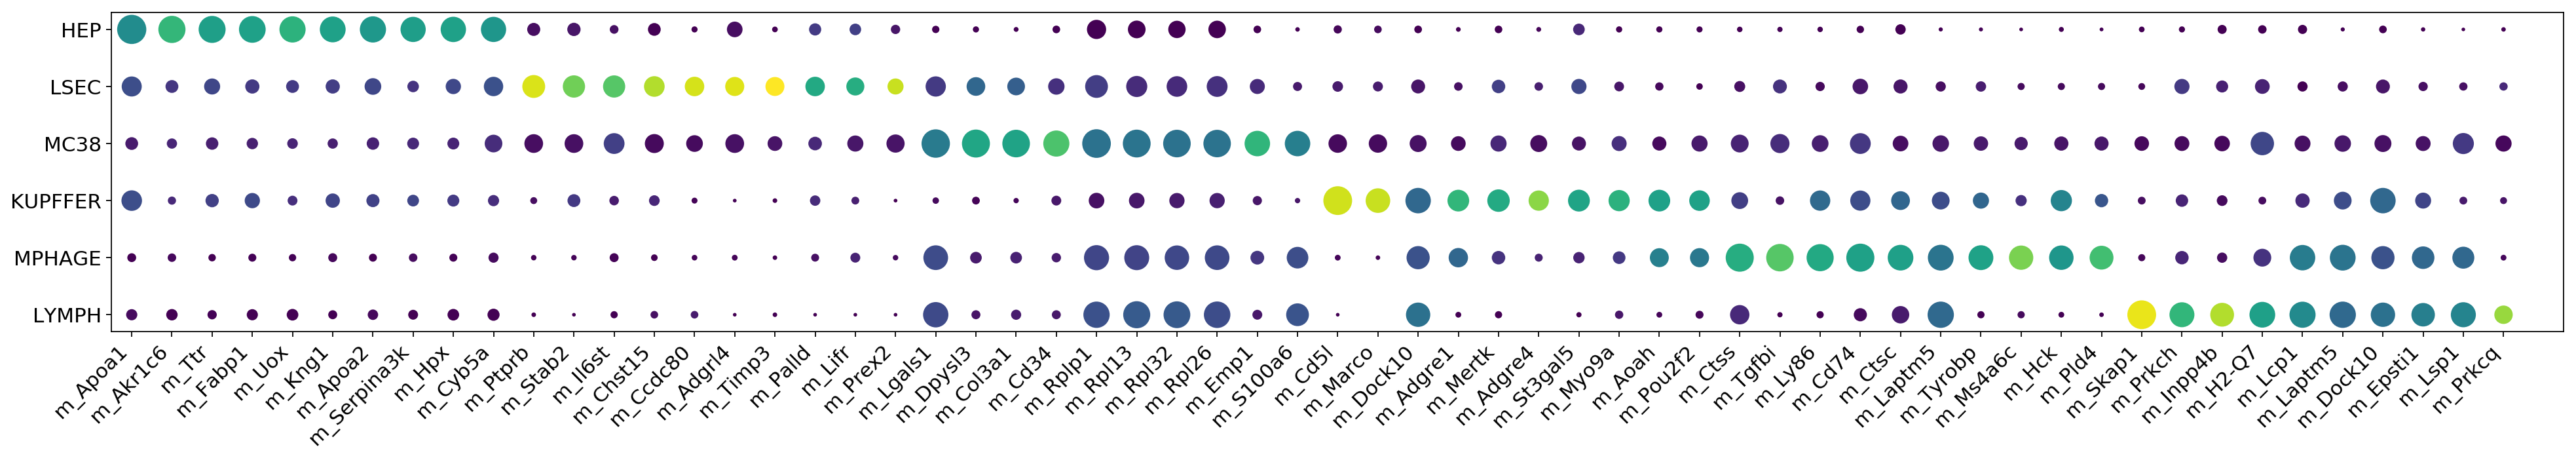

In [374]:
plt.figure(figsize=(30,4))
plt.scatter([i[::-1][0] for i in it.product(range(len(cts))[::-1], 
                                            range(len(genes_list)))], 
            [i[::-1][1] for i in it.product(range(len(cts))[::-1], 
                                            range(len(genes_list)))], 
            s=500*np.ravel(percentdf.values), 
            c=np.ravel(expdf_norm.values));
plt.xticks(range(len(genes_list)),labels=genes_list, rotation=45)
plt.yticks(range(len(cts)),labels=cts[::-1])
plt.xlim(-0.5,len(cts)*len(genes['HEP']) + 0.5)
plt.grid(False)
ax = plt.gca()
ax.set_xticklabels(genes_list, ha='right');
plt.savefig(prefix + '10x/2020112/figures2/10x.L20C1.bubble.pdf')

# EXTRA CODE


# Merge the Datasets

I need to combine the 10x data with L20C1. I'll merge the raw counts after filtering, and then run Harmony, followed by dimensionality reduction and clustering. 

Concatenate on the inner join of genes, and get rid of the batch key.

In [111]:
data['adata_for_concat'] = sc.read_10x_h5(prefix + '10x/5prime_liver/outs/raw_feature_bc_matrix.h5')
data['adata_for_concat'].var_names_make_unique()

reading /data/xyzeq/10x/liver3/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


In [112]:
l20c1_for_concat = sc.read_h5ad(l20c1_prefix + 'adata.1.h5ad')

In [113]:
print(data['adata_for_concat'].shape)
print(l20c1_for_concat.shape)

(737280, 64591)
(4788, 50241)


In [114]:
data['adata_for_concat'] = data['adata_for_concat'][[i[:18] for i in data['adata'].obs_names]].copy()

In [115]:
l20c1_for_concat = l20c1_for_concat[l20c1.obs_names].copy()

# l20c1_for_concat = l20c1_for_concat[:,[i for i in l20c1_for_concat.var_names if i.startswith('mm10_')]].copy()
# l20c1_for_concat.var_names
# l20c1_for_concat.var_names = [i[5:] for i in l20c1_for_concat.var_names]

In [116]:
print(data['adata_for_concat'].shape)
print(l20c1_for_concat.shape)

(1982, 64591)
(4788, 50241)


In [117]:
new_names = list()
for i in l20c1_for_concat.var_names:
    if i.startswith('hg19_'):
        new_names.append('H_' + i[5:])
    else:
        new_names.append('m_' + i[5:])
l20c1_for_concat.var_names = new_names

In [118]:
new_names = list()
for i in data['adata_for_concat'].var_names:
    if i.startswith('GRCh38_'):
        new_names.append('H_' + i[7:])
    else:
        new_names.append('m_' + i[7:])
data['adata_for_concat'].var_names = new_names

In [119]:
concat = data['adata_for_concat'].concatenate(l20c1_for_concat, join='inner')

In [120]:
concat.shape

(6770, 39993)

In [121]:
concat.obs.index = [i[:-2] for i in concat.obs.index]

AttributeError: module 'scanpy.tools' has no attribute 'ingest'

### USING HARMONY:

Write to file so I can run Harmony in a separate notebook.

In [245]:
concat.write_h5ad(prefix + '10x/20191102/concat.liver1.L20C1.derek.h5ad')

... storing 'cell_call' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical


Normalize per cell and log1p. I do this in Harmony separately using Seurat.

In [65]:
sc.pp.normalize_per_cell(concat, counts_per_cell_after=1e6)
sc.pp.log1p(concat)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Read back in the embeddings from Harmony.

In [66]:
harmony = pd.read_csv(prefix + '10x/20191102/harmony.embeddings.liver1.L20C1.derek.all.csv')
concat.obsm['X_pca'] = harmony.values

In [67]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(concat,n_neighbors=5,n_pcs=50) # using all available embeddings, numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:00)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


### End using Harmony

### USING BBKNN:

In [224]:
sc.pp.normalize_per_cell(concat, counts_per_cell_after=1e6)
sc.pp.log1p(concat)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
        as `zero_center=True`, sparse input is densified and may lead to huge memory consumption
    finished (0:00:03)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


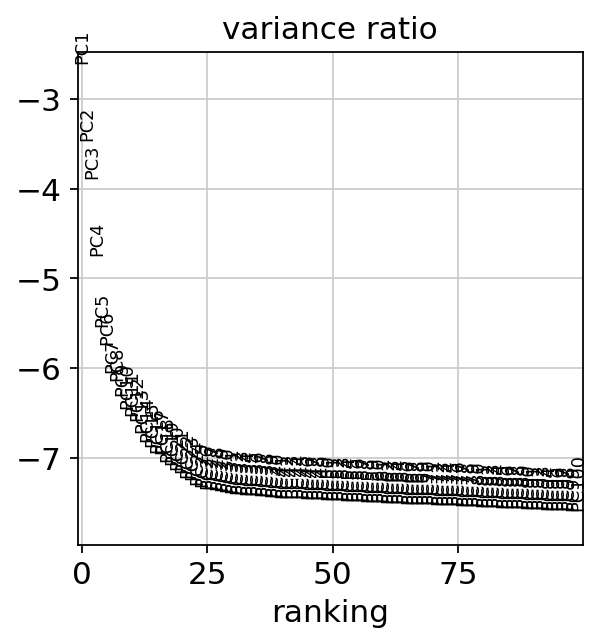

In [225]:
warnings.filterwarnings('ignore')
sc.pp.pca(concat,n_comps=100)
sc.pl.pca_variance_ratio(concat,log=True, n_pcs=100)
warnings.filterwarnings('default')

In [226]:
bbknn_adata = bbknn.bbknn(concat, neighbors_within_batch=5, n_pcs=0, copy=True)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)


### End using BBKNN

Remap the batches to make them more descriptive.

In [68]:
concat.obs['batch'] = concat.obs['batch'].map({'0': '10x', '1':'XYZeq'})

In [69]:
sc.tl.umap(concat, spread=3)

computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [70]:
sc.tl.leiden(concat,resolution=0.2)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'cell_call' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical


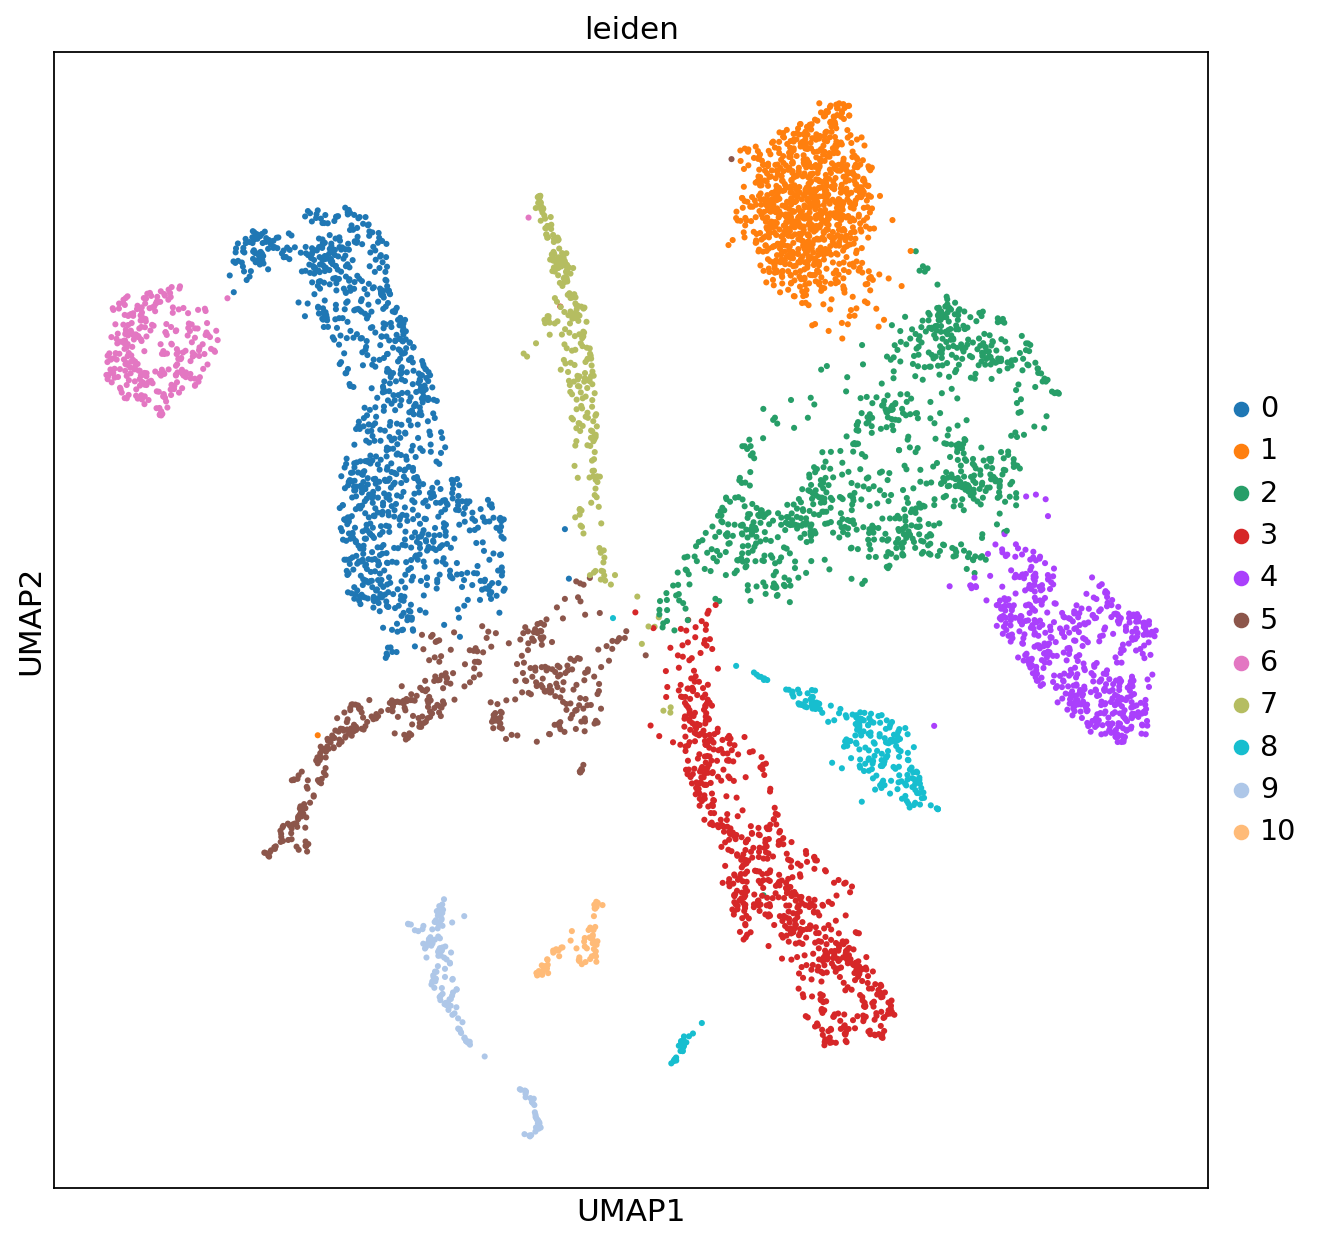

In [71]:
fig, ax = plt.subplots(1,1,figsize=(8.5,8))
sc.pl.umap(concat,color=['leiden'], size=30, ax=ax, return_fig=False, show=False)
plt.tight_layout()
plt.savefig(prefix + '10x/20191102/figures/concat.umap.leiden.pdf')

In [72]:
batches = concat.obs['batch'].unique() # get a list of the batches
# make a new column in the `.obs` for each batch that is of dtype `int` and that just takes on values of 0 and 1 so that it gets plotted as a continuous variable instead of a categorical one
for batch in batches:
    concat.obs['batch_%s' % batch] = (concat.obs['batch'] == batch).astype(int)

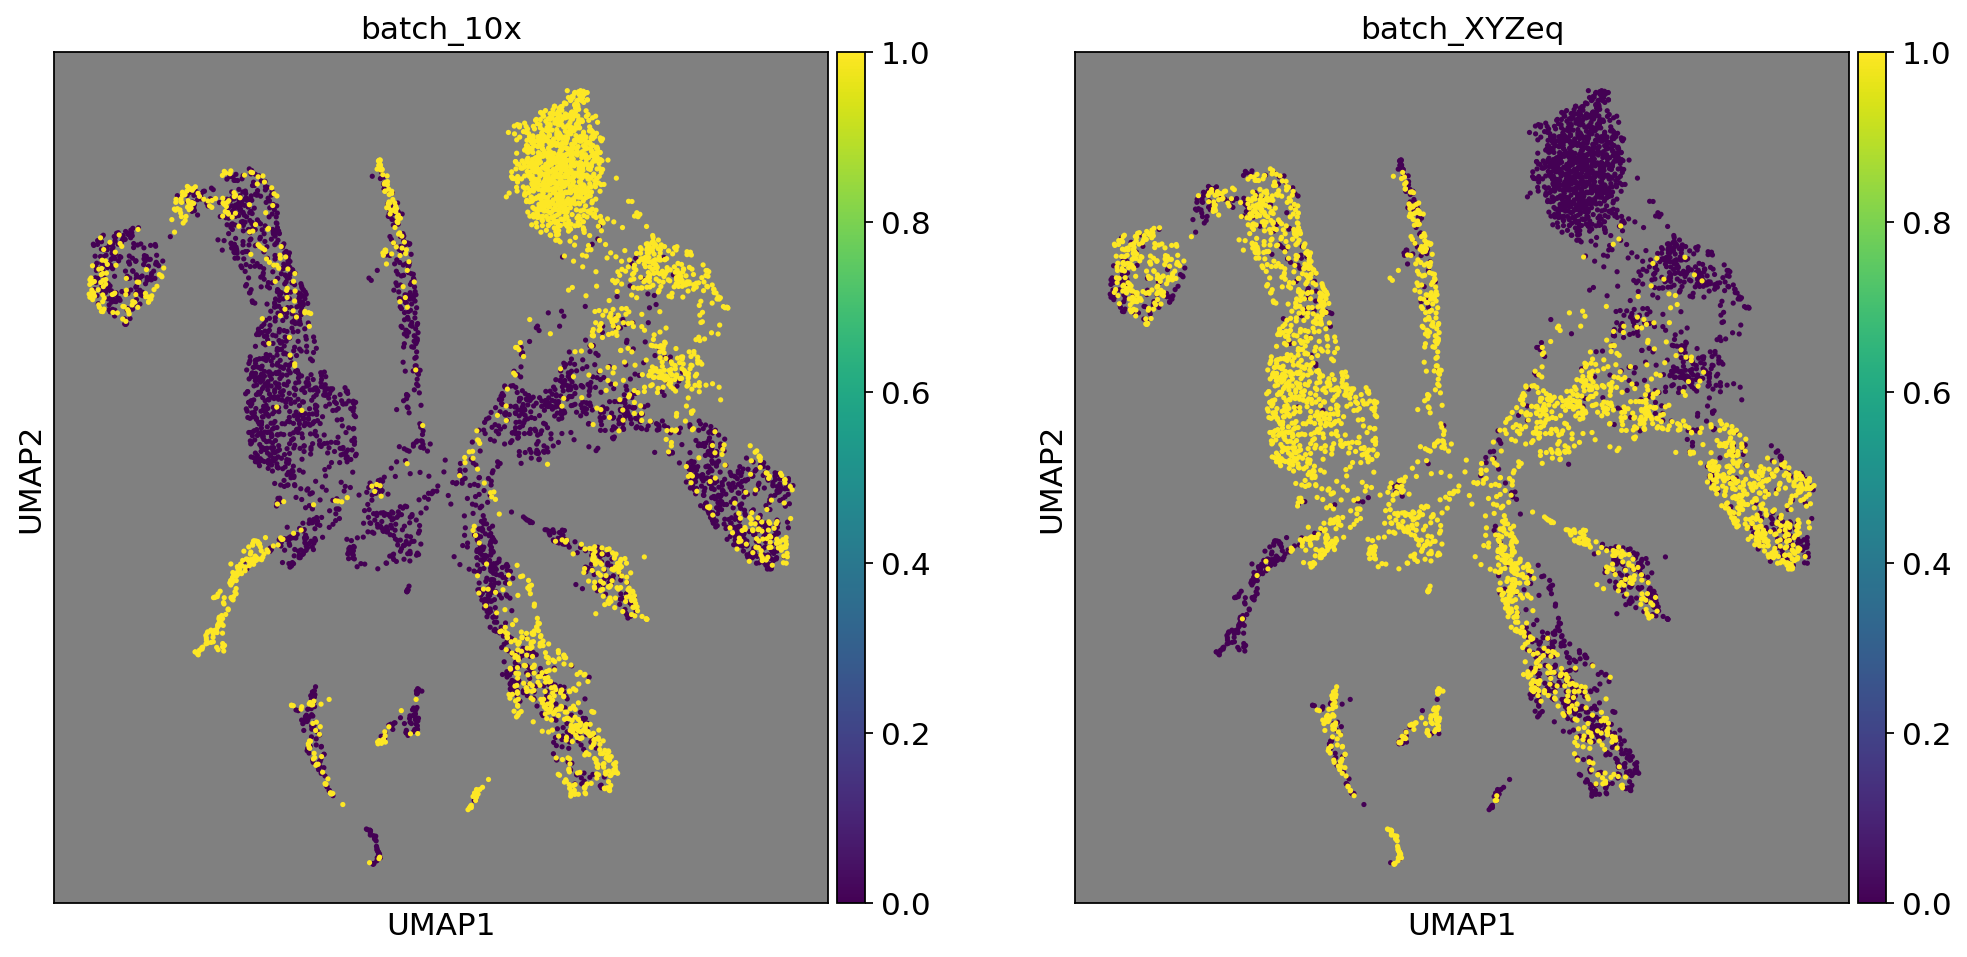

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
# make a new column in the `.obs` for each batch that is of dtype `int` so that it gets plotted as a continuous variable instead of a categorical one
for batch, ax in zip(batches, np.ravel(ax)):
    ax.set_facecolor('gray')
    sc.pl.umap(concat, color=['batch_%s' % batch], ax=ax, sort_order=True, show=False, return_fig=False)
plt.savefig(prefix + '10x/20191102/figures/concat.umap.batch.separate.overlay.pdf')

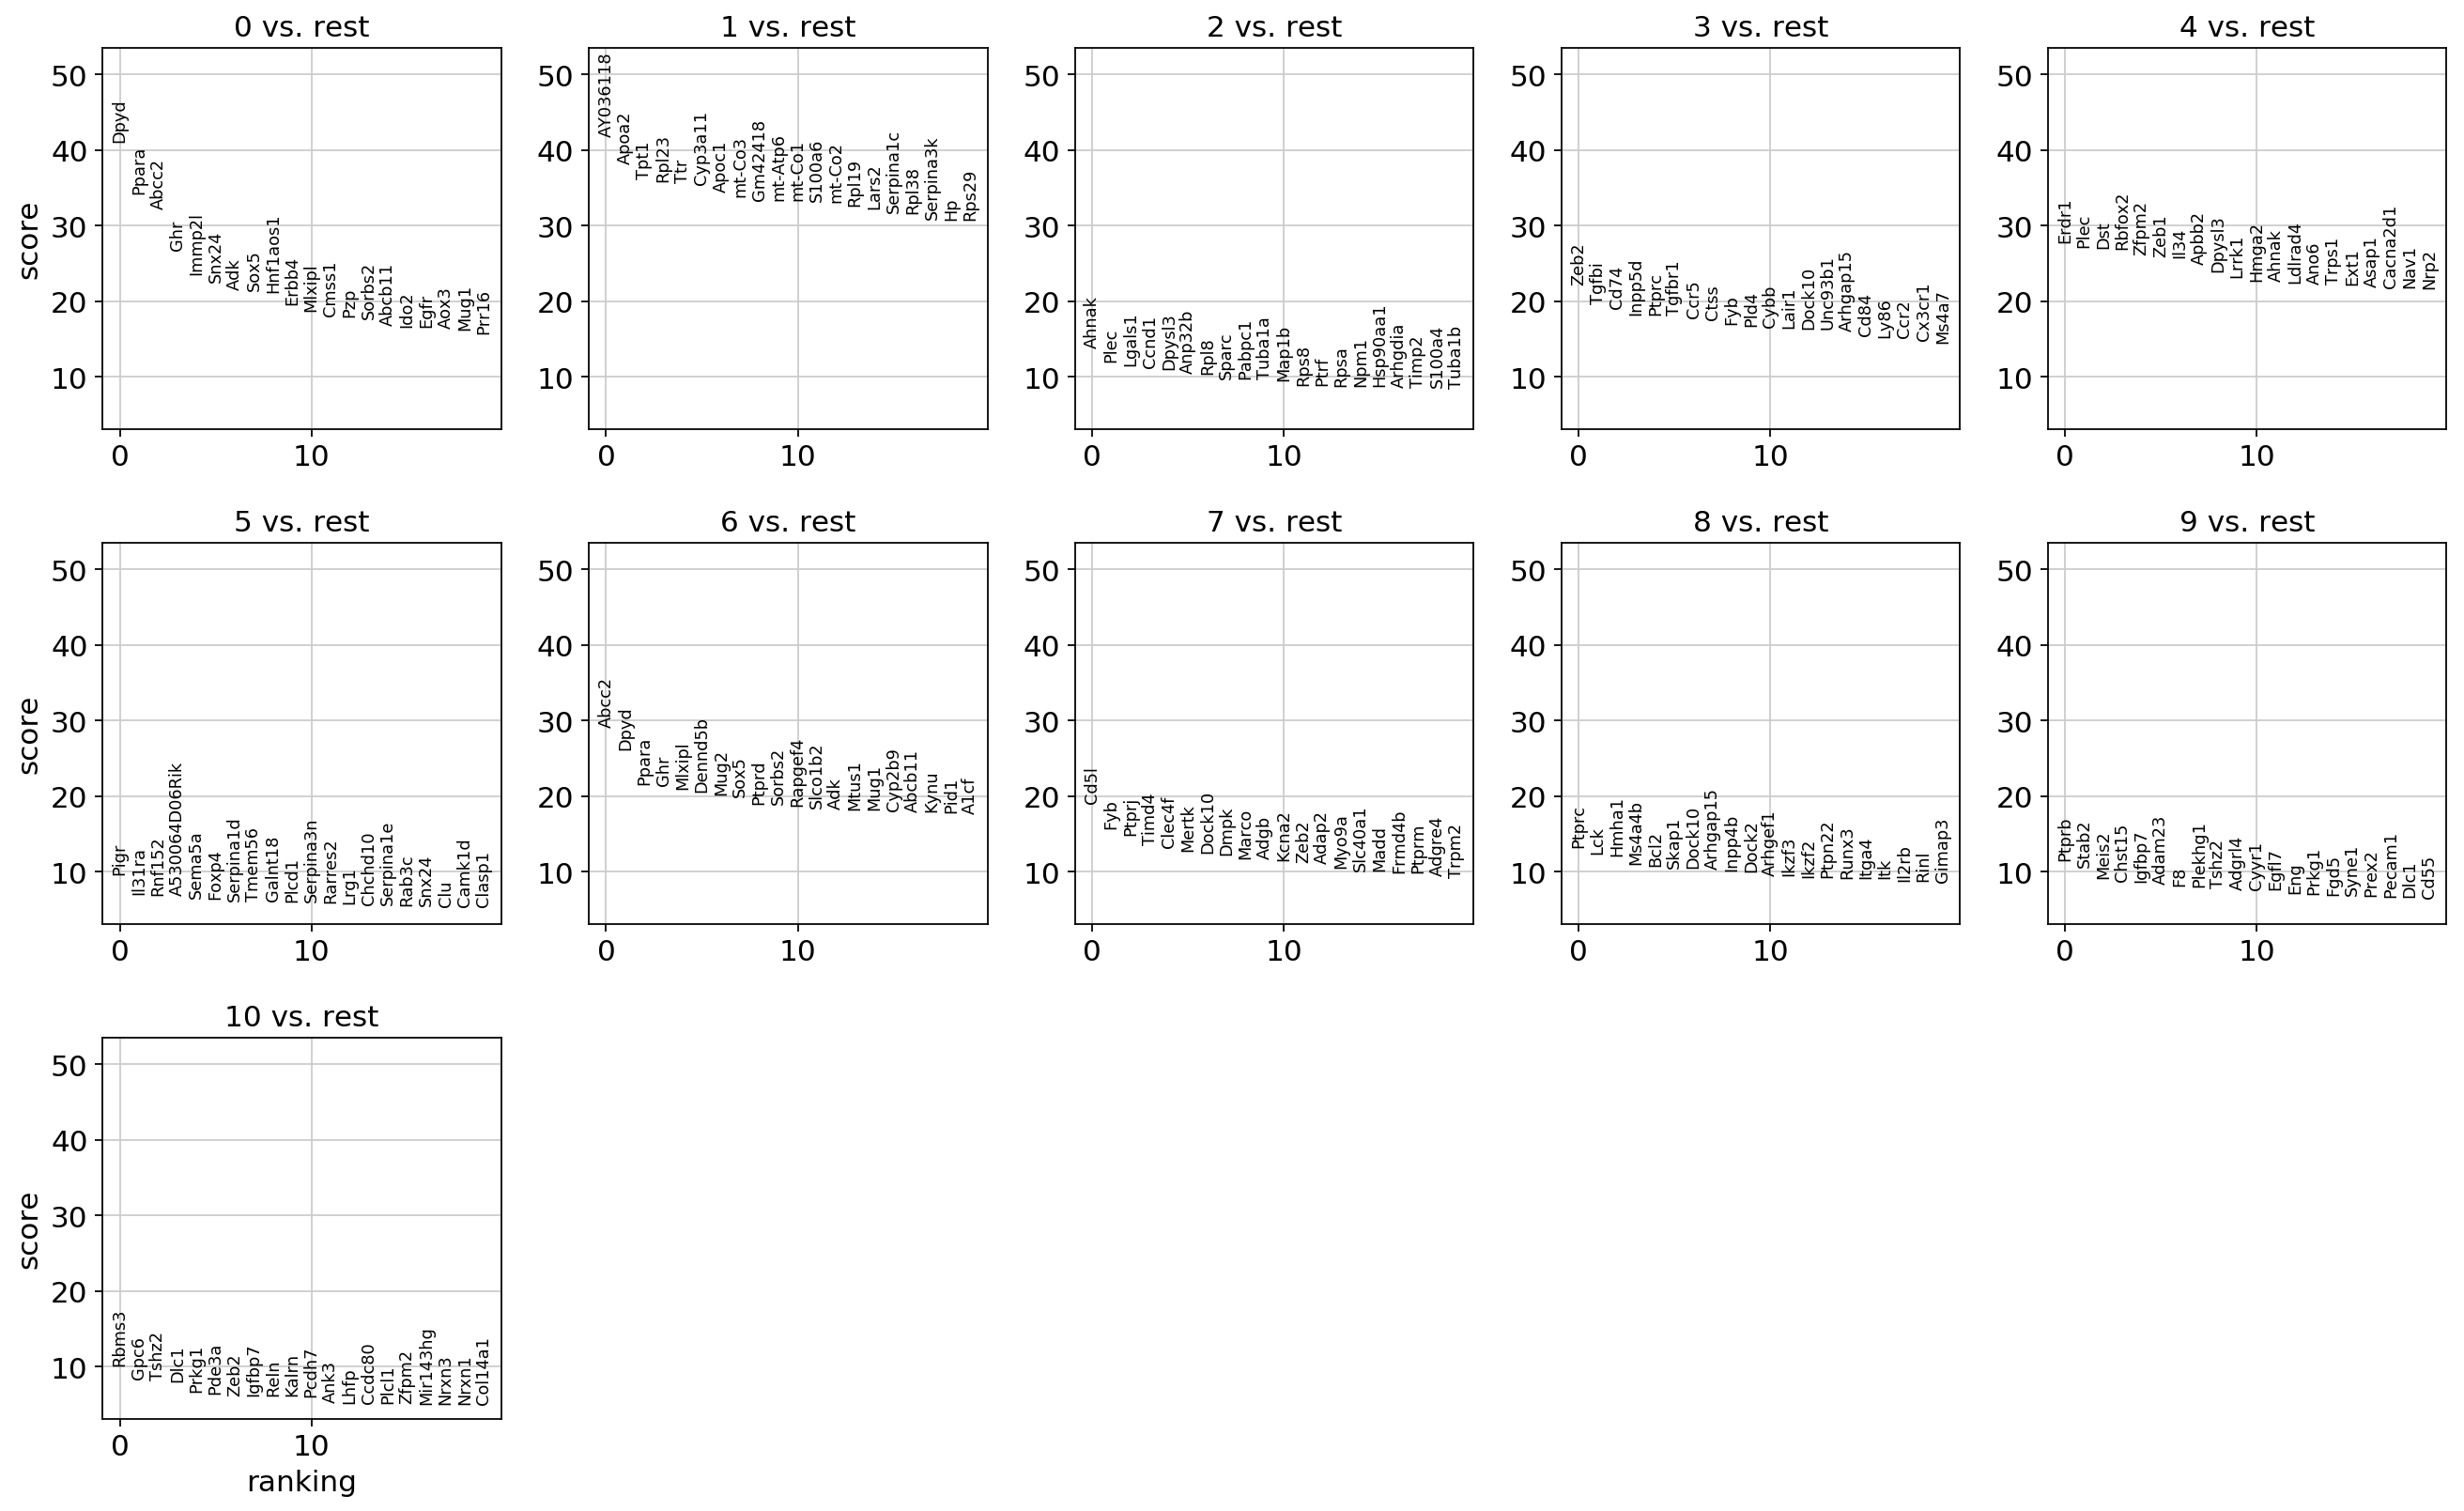

In [74]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat, groupby='leiden')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat, ncols=5)
sc.settings.verbosity = 4

In [75]:
# gsea_dicts = dict()
# for i in tqdm(range(11)):
#     gsea_dicts[i] = dict()
#     gsea_dicts[i]['enrichr'] = enrichr(list(concat.uns['rank_genes_groups']['names'][str(i)][:25]), plot=True)
#     gsea_dicts[i]['annotation'] = input() # ensure there is some time between the requests, else it will error

In [76]:
# gsea_dicts = {0: {'annotation': 'Hep (Chol+)'}, 1: {'annotation': 'MPhage'}, 2: {'annotation': 'ECM (Mito)'}, 3: {'annotation': 'Hep (Gly)'}, 4: {'annotation': 'Ribo'}, 5: {'annotation': 'ECM (Coll)'}, 6: {'annotation': 'Hep (Chol++)'}, 7: {'annotation': 'T/NK'}, 8: {'annotation': 'Kupffer'}, 9: {'annotation': 'LSECs'}, 10: {'annotation': 'B'}}
# gsea_dicts = {0: {'annotation': 'Hep_1'}, 1: {'annotation': 'MPhage'}, 2: {'annotation': 'MC38_1'}, 3: {'annotation': 'Hep_2'}, 4: {'annotation': 'MC38_2'}, 5: {'annotation': 'MC38_3'}, 6: {'annotation': 'Hep_3'}, 7: {'annotation': 'T/NK'}, 8: {'annotation': 'Kupffer'}, 9: {'annotation': 'LSECs'}, 10: {'annotation': 'B'}}

In [77]:
# for i in range(11):
#     print(str(i) + ': ' + gsea_dicts[i]['annotation'])

In [78]:
ctdict = dict()
ctdict['Hep'] = [0, 1, 5, 6]
ctdict['MC38'] = [2, 4]
ctdict['Macrophage'] = [3]
ctdict['Kupffer'] = [7]
ctdict['Lymphocyte'] = [8]
ctdict['LSEC'] = [9]
ctdict['Stellate'] = [10]
concat.obs['celltype'] = concat.obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        concat.obs['celltype'].replace(r'^%s$' % str(clust),ct, regex=True, inplace=True)
concat.obs['celltype'] = concat.obs['celltype'].astype('category')

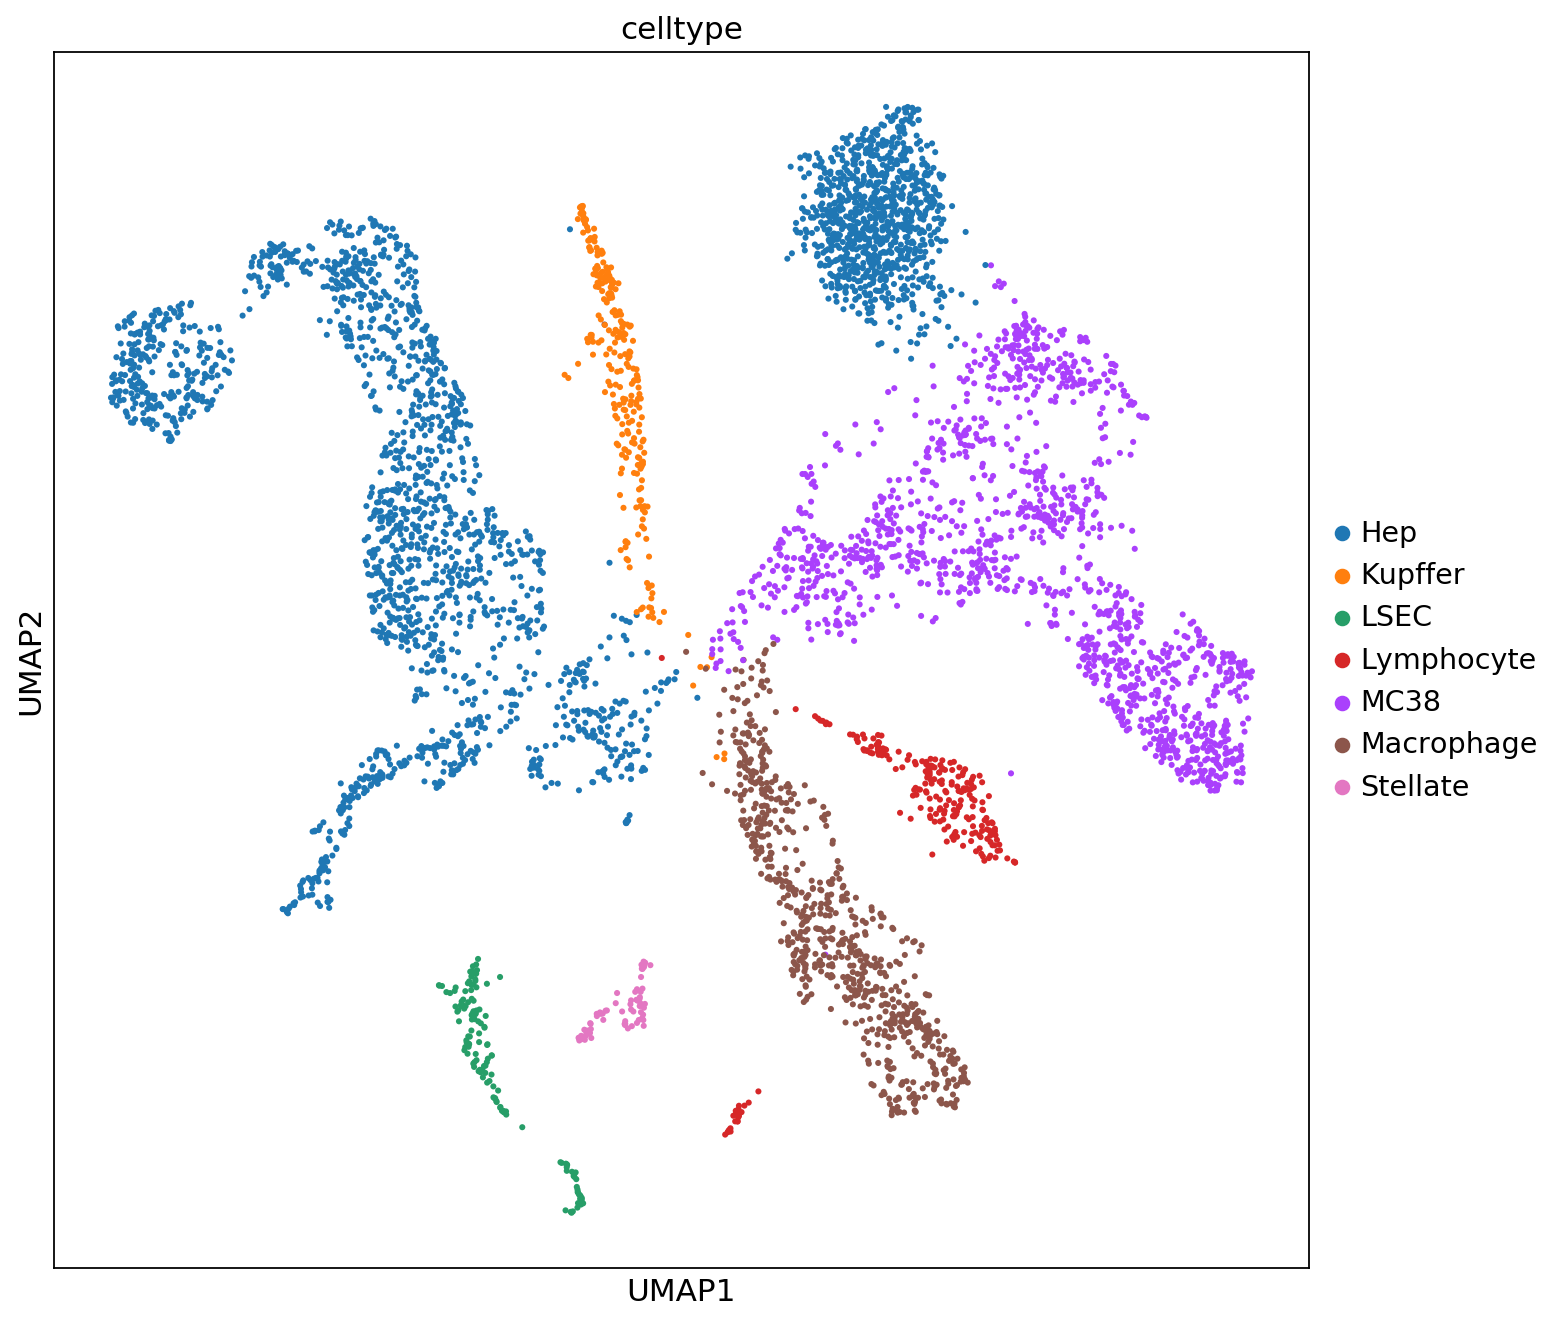

In [81]:
fig, ax = plt.subplots(1,1,figsize=(10,8.5))
sc.pl.umap(concat, color='celltype', size=30, ax=ax, show=False, return_fig=False)
plt.tight_layout()
plt.savefig(prefix + '10x/20191102/figures/concat.umap.celltype.pdf')

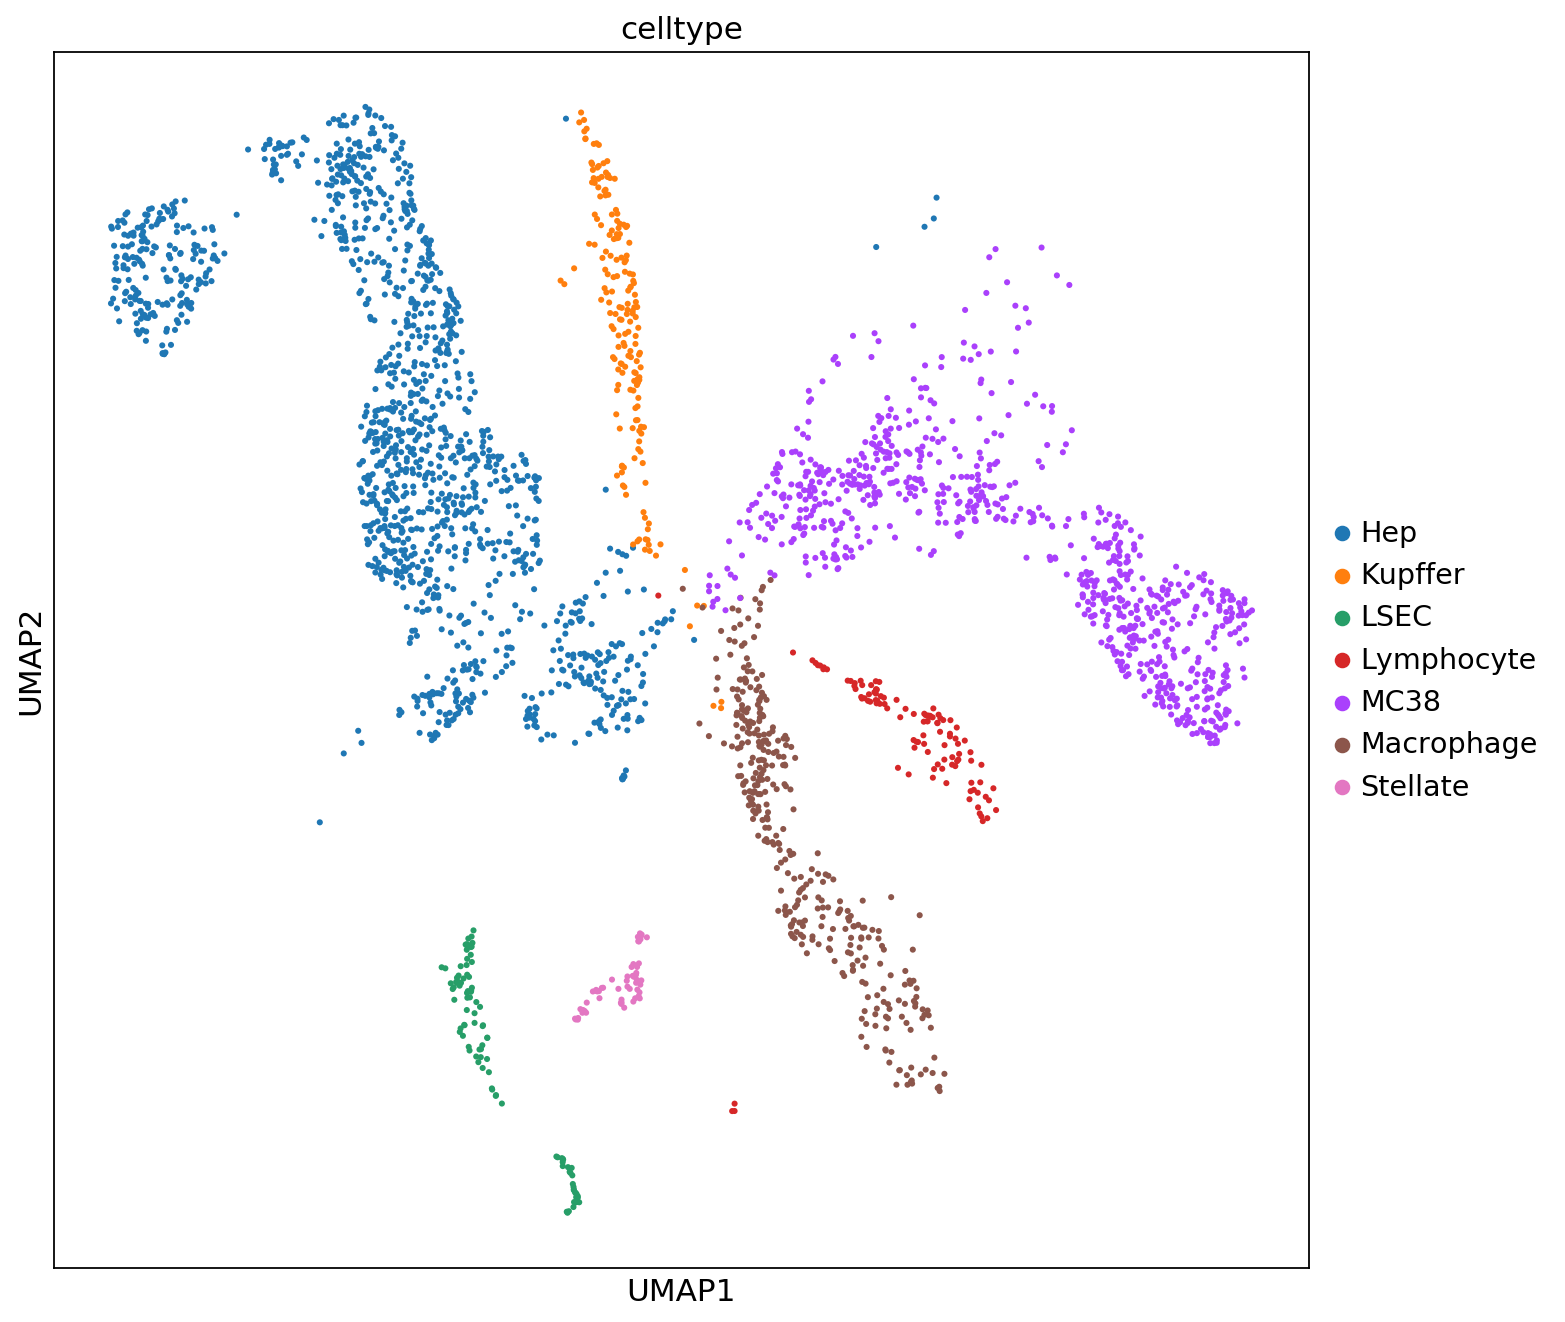

In [79]:
fig, ax = plt.subplots(1,1,figsize=(10,8.5))
sc.pl.umap(concat[concat.obs['batch'] == 'XYZeq'], color='celltype', size=30, ax=ax, show=False, return_fig=False)
plt.tight_layout()
plt.savefig(prefix + '10x/20191102/figures/concat.umap.XYZeq.only.pdf')

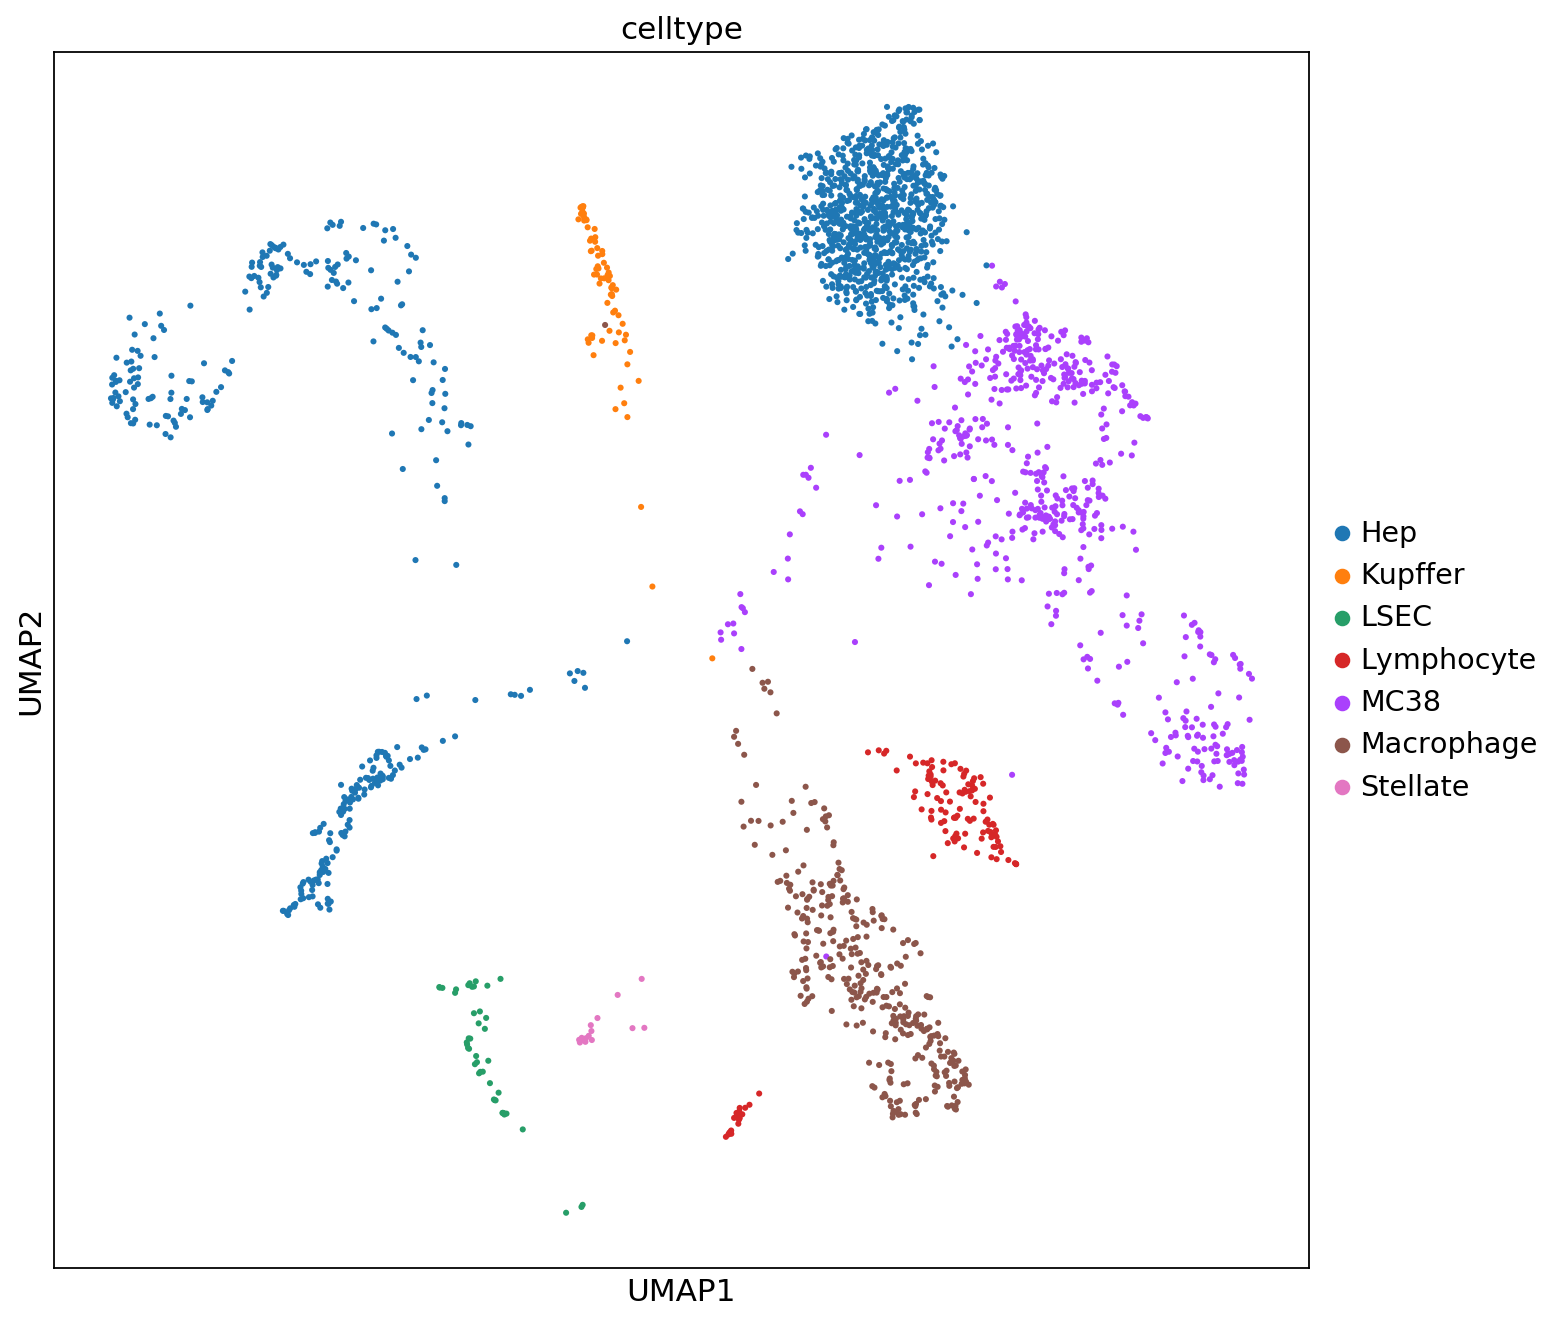

In [91]:
fig, ax = plt.subplots(1,1,figsize=(10,8.5))
sc.pl.umap(concat[concat.obs['batch'] == '10x'], color='celltype', size=30, ax=ax, show=False, return_fig=False)
plt.tight_layout()
plt.savefig(prefix + '10x/20191102/figures/concat.umap.XYZeq.only.pdf')

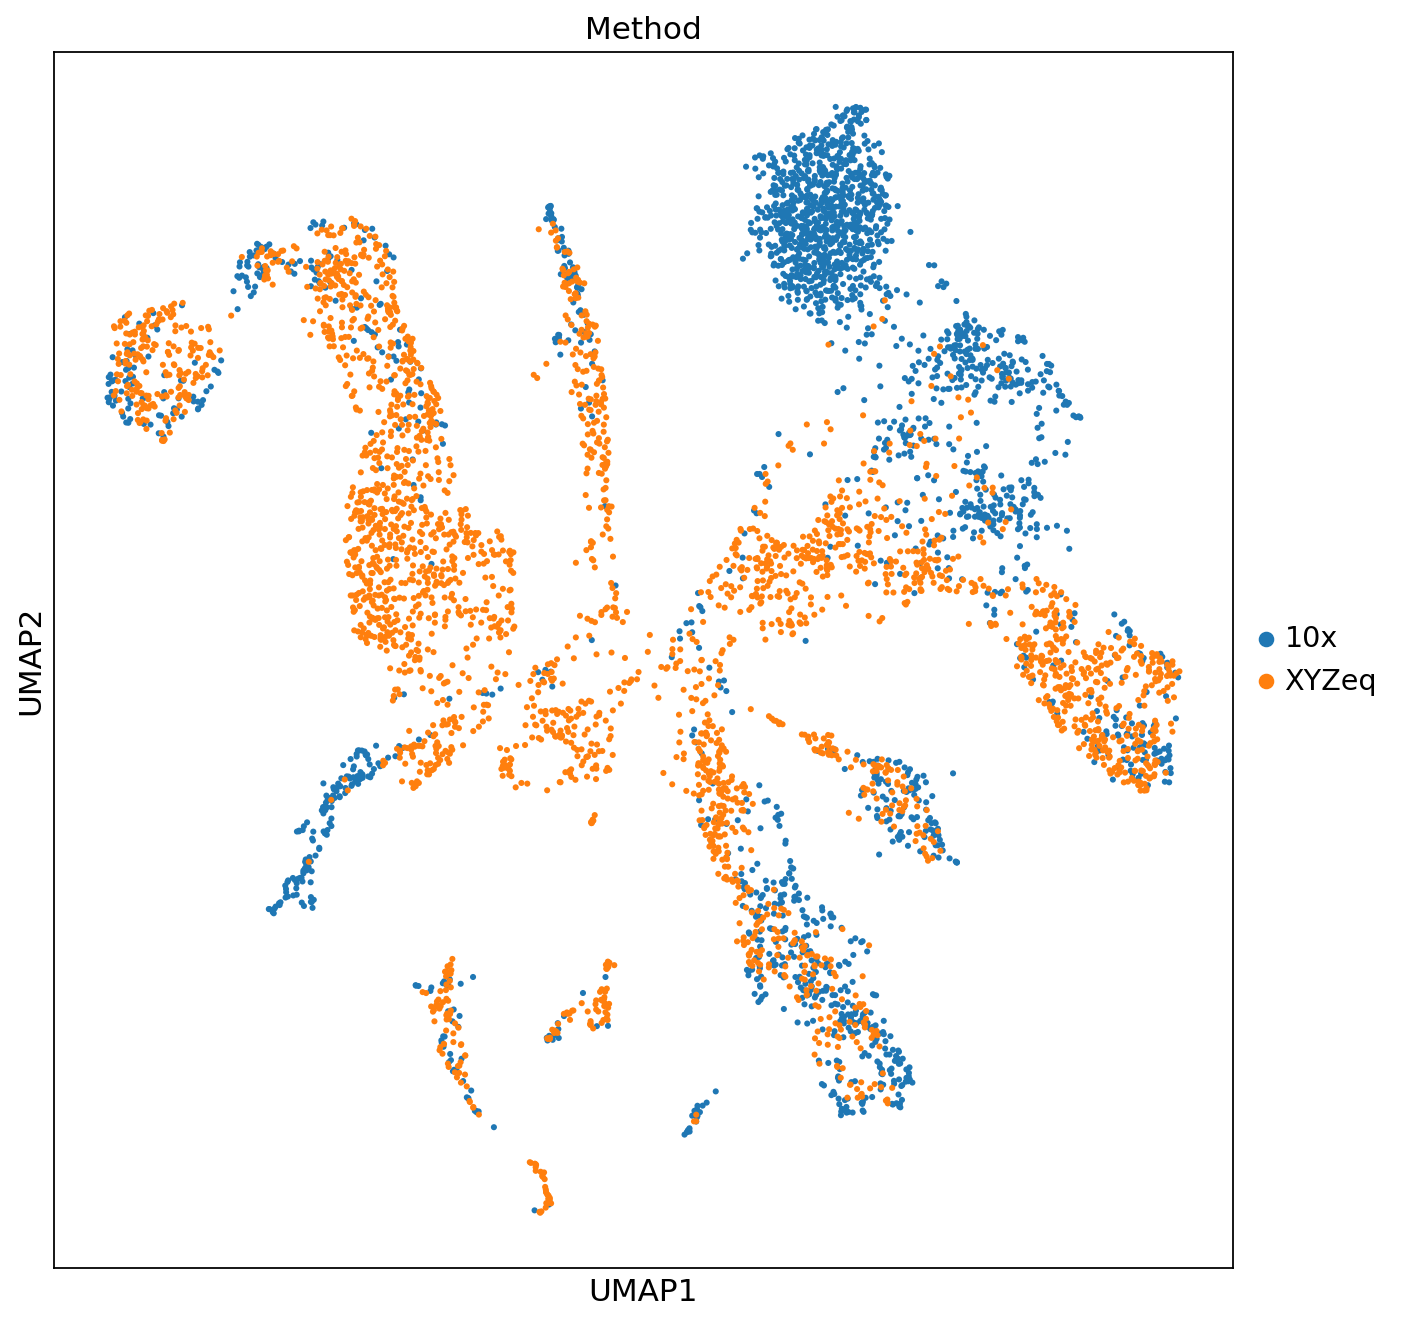

In [445]:
fig, ax = plt.subplots(1,1,figsize=(9,8.5))
sc.pl.umap(concat,color=['batch'], size=30, ax=ax, return_fig=False, show=False, title='Method')
plt.tight_layout()
plt.savefig(prefix + '10x/20191102/figures/concat.umap.10x.only.pdf')

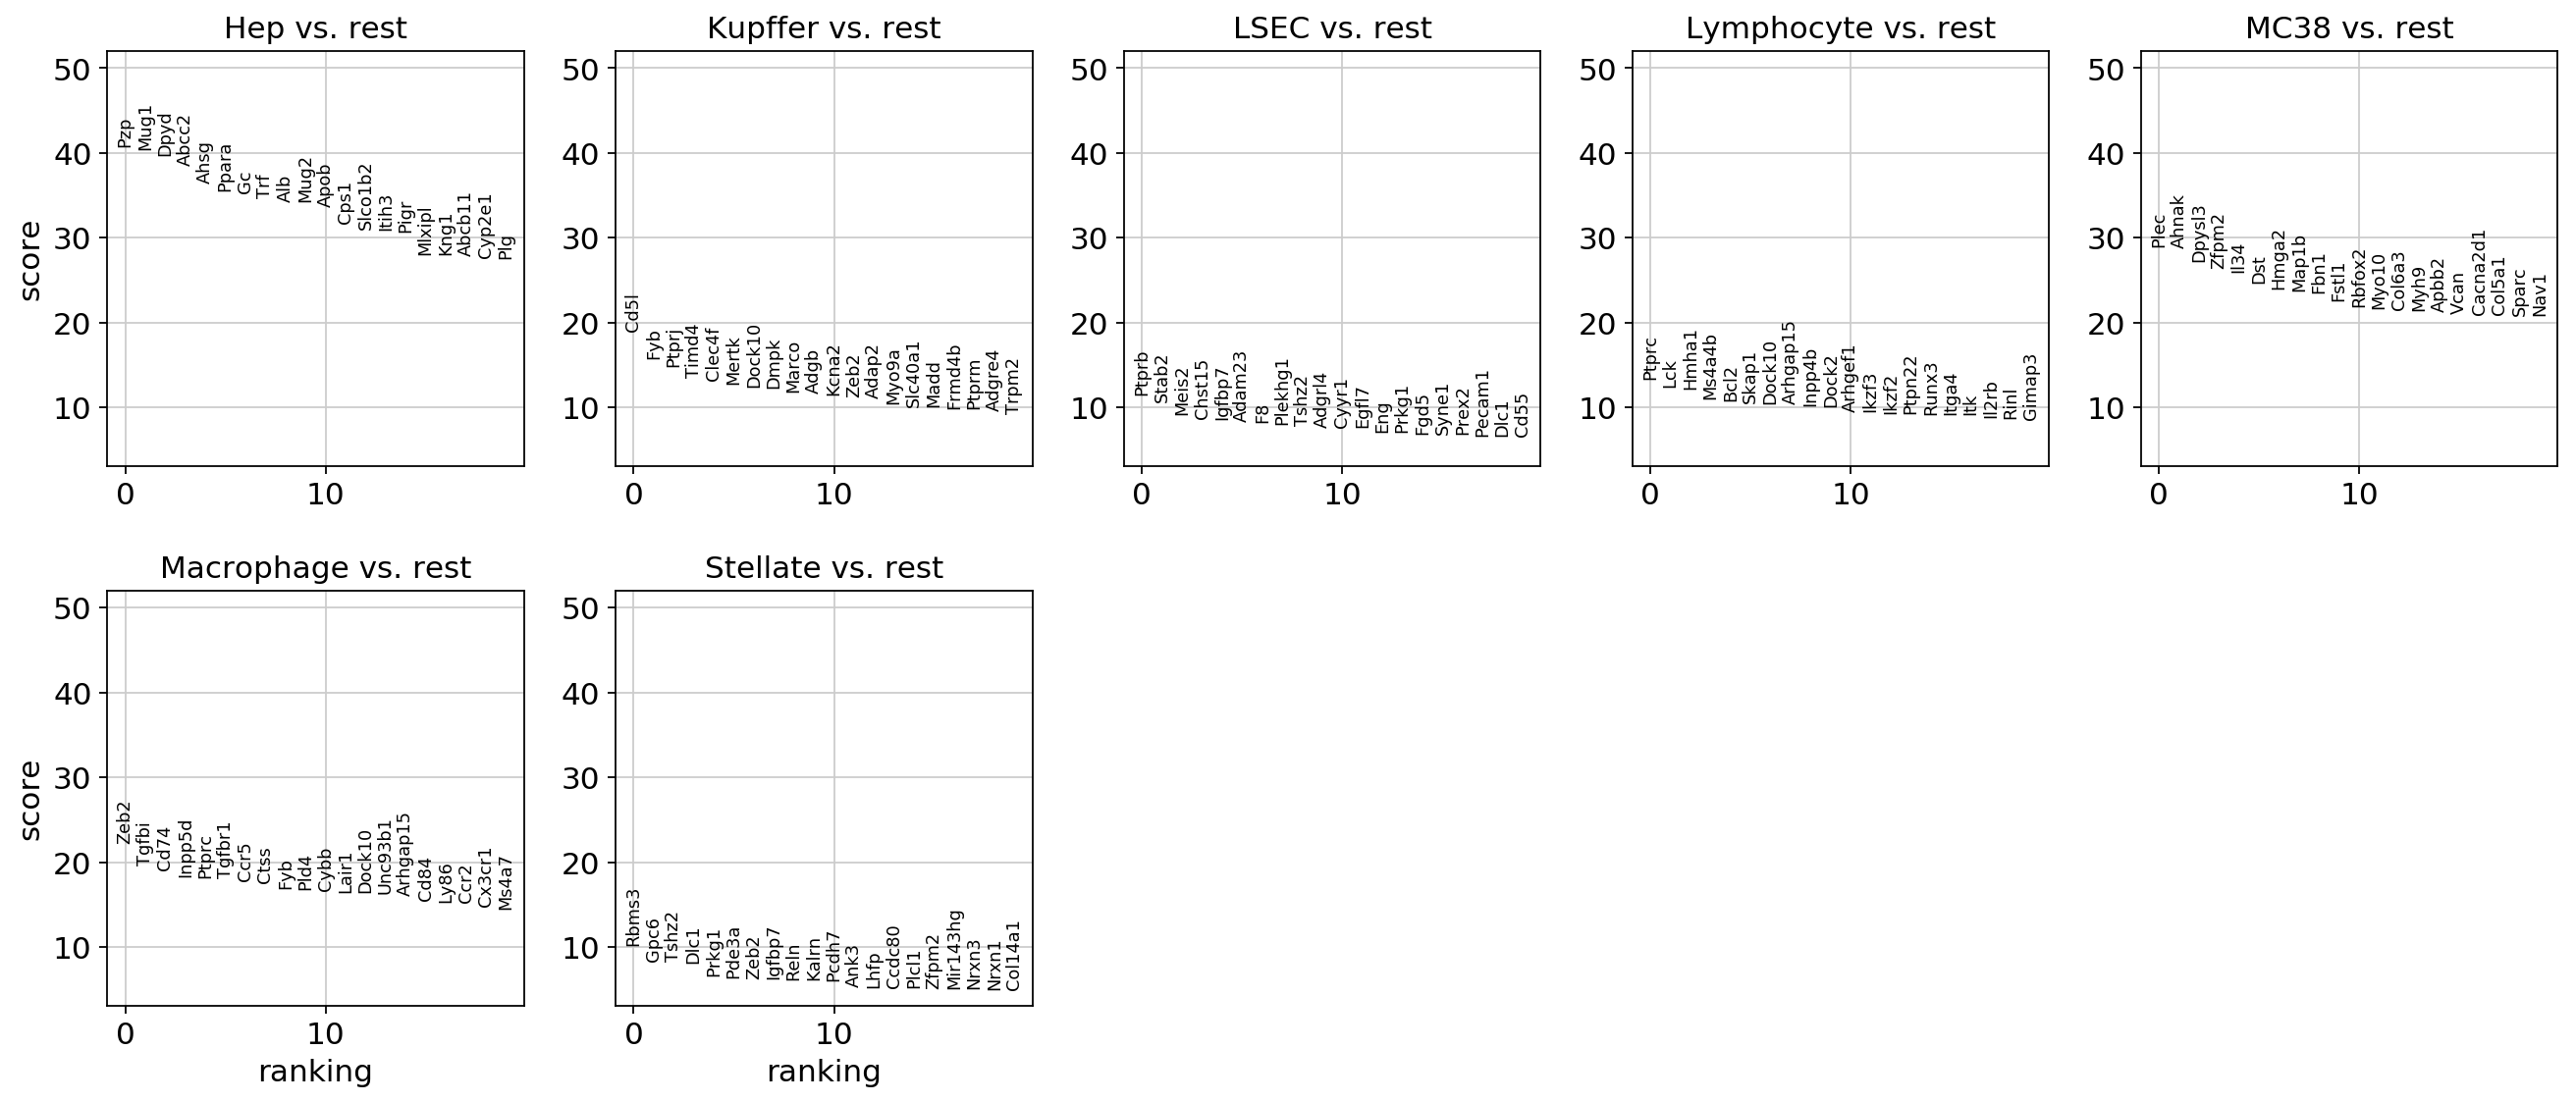

In [92]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat,groupby='celltype')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat, ncols=5)
sc.settings.verbosity = 3

In [93]:
groups = 

In [93]:
concat.obs['celltype'].unique()

In [94]:
groups

[MC38, Hep, LSEC, Macrophage, Stellate, Kupffer, Lymphocyte]
Categories (7, object): [MC38, Hep, LSEC, Macrophage, Stellate, Kupffer, Lymphocyte]

In [ ]:
gsea_dicts = dict()
for i in tqdm(groups):
    gsea_dicts[i] = dict()
    print(i)
    gsea_dicts[i]['enrichr'] = enrichr(list(concat.uns['rank_genes_groups']['names'][i][:25]), plot=True)
    gsea_dicts[i]['annotation'] = input() # ensure there is some time between the requests, else it will error